<a href="https://colab.research.google.com/github/AnishSharma1/Science-Fair-Project/blob/main/Copy_of_Tetramer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install ColabFold Dependencies
%%time
import os

# Configuration
USE_AMBER = False
USE_TEMPLATES = False
PYTHON_VERSION = '3.10'

if not os.path.isfile("COLABFOLD_READY"):
  print("Installing ColabFold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("Installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY"):
  print("Installing hhsuite...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
  os.system("touch HH_READY")

if USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("Installing amber...")
  os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch AMBER_READY")

print("Dependencies installed successfully!")

#@title Load Pipeline Output and Define Sequences
# Load metadata from pipeline (upload colabfold_input_metadata.csv)
from google.colab import files
uploaded = files.upload()
metadata_file = 'colabfold_input_metadata.csv'  # Assume uploaded
import pandas as pd
metadata = pd.read_csv(metadata_file)

# HLA chains (from your code)
hla_dra1_0101 = "MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHFFNGTERVRLLERCIYNQEEGSVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAAVDTYCRHNYGVGESFTVQRRVEPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS"
hla_drb1_1501 = "MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHFFNGTERVRLLERCIYNQEEGSVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAAVDTYCRHNYGVGESFTVQRRVEPKVTVYPSKTQPLQHHNLLVCSVSGFYPGSIEVRWFRNGQEEKTGVVSTGLIHNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVGGFVLGLLFLGAGLFIYFRNQKGHSGLQPTGFLS"

# Create pMHC complexes
complex_queries = []
jobname = "mhc_trimer_analysis"
os.makedirs(jobname, exist_ok=True)

print("Creating MHC trimer complexes (alpha:beta:peptide)...")

for _, row in metadata.iterrows():
    # For MHC-I, use single chain proxy (adjust if A chain available)
    if row['myelin_mhc_class'] == 'MHC-I':
        myelin_complex = f"{hla_drb1_1501}:{row['myelin_sequence']}"  # Proxy
        ebv_complex = f"{hla_drb1_1501}:{row['ebv_sequence']}"
    else:
        myelin_complex = f"{hla_dra1_0101}:{hla_drb1_1501}:{row['myelin_sequence']}"
        ebv_complex = f"{hla_dra1_0101}:{hla_drb1_1501}:{row['ebv_sequence']}"

    complex_queries.append((f"{row['pair_id']}_myelin", myelin_complex))
    complex_queries.append((f"{row['pair_id']}_ebv", ebv_complex))
    print(f"  - {row['pair_id']}_myelin")
    print(f"  - {row['pair_id']}_ebv")

# Save queries to file
queries_path = os.path.join(jobname, "queries.fasta")
with open(queries_path, "w") as f:
    for query_name, query_sequence in complex_queries:
        f.write(f">{query_name}\n{query_sequence}\n")

#@markdown ### MSA Options
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}

#@markdown ### Model Settings
model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
num_models = 1 #@param [1, 2, 3, 4, 5] {type:"raw"}
num_recycles = 3 #@param [1, 3, 6, 12, 24] {type:"raw"}
num_seeds = 1 #@param [1, 2, 3, 4, 5] {type:"raw"}

#@markdown ### Advanced Settings
use_dropout = False #@param {type:"boolean"}
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
max_msa = None #@param {type:"raw"}
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
calc_extra_ptm = True #@param {type:"boolean"}

#@markdown ### Output Settings
save_all = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
dpi = 200 #@param {type:"integer"}

print("Configuration complete!")
print(f"Model type: {model_type} (forced multimer for MHC class II)")
print(f"Number of complexes: {len(complex_queries)}")
# **IMPORTANT:** Update this print statement to reflect the new structure
print(f"Complex format: alpha_chain:beta_chain:EBV_peptide:Myelin_peptide")

#@title Run MHC Docking Predictions

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

from pathlib import Path
from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type

# Setup logging
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

# Get queries and set model type
queries, is_complex = get_queries(queries_path)
# Force multimer model for MHC complexes
model_type = "alphafold2_multimer_v3"
print(f"Using model type: {model_type} for MHC class II complexes")

# Download AlphaFold parameters
print("Downloading AlphaFold parameters...")
download_alphafold_params(model_type, Path("."))

# Configure MSA settings
if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
else:
    use_cluster_profile = True

print(f"Starting MHC class II docking predictions for {len(queries)} complexes...")
# **IMPORTANT:** Update this print statement to reflect the new structure
print(f"Each complex: HLA-DRA*01:01 + HLA-DRB1*15:01 + EBV_peptide + Myelin_peptide (Tetramer)")

# Run predictions
results = run(
    queries=queries,
    result_dir=jobname,
    use_templates=use_templates,
    num_relax=0,  # No relaxation for faster processing
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=num_models,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1, 2, 3, 4, 5][:num_models],
    is_complex=True,  # Force complex mode
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy="greedy",
    stop_at_score=float(100),
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    calc_extra_ptm=calc_extra_ptm,
)

# Create results zip
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

print("\n" + "="*60)
print("MHC CLASS II DOCKING ANALYSIS COMPLETED!")
print("="*60)
print(f"Results saved in: {jobname}")
print(f"Download results: {results_zip}")
print(f"Total complexes analyzed: {len(complex_queries)}")
# **IMPORTANT:** Update this print statement to reflect the new structure
print(f"Complex format: HLA-DRA*01:01 + HLA-DRB1*15:01 + EBV_peptide + Myelin_peptide (Tetramer)")
print("\nYou can now analyze the structural models for:")
print("• MHC-peptide binding interfaces")
print("• Peptide positioning in the binding groove")
print("• Molecular mimicry between EBV and myelin peptides")
print("• Binding affinity predictions")
print("• Chain-specific pTM scores")

Dependencies installed successfully!


Saving Queries from Colab.fasta to Queries from Colab (2).fasta
Creating MHC trimer complexes (alpha:beta:peptide)...


KeyError: 'myelin_mhc_class'

In [ ]:
#@title Fix: Copy Parameters from /content/params
import os
import shutil
from pathlib import Path

# Source and target directories
source_dir = Path("/content/params")
target_dir = Path("/root/.cache/colabfold/params")

print(f"Source: {source_dir}")
print(f"Target: {target_dir}")

# Check what's in /content/params
print("\nFiles in /content/params:")
if source_dir.exists():
    files = list(source_dir.glob("*"))
    for f in sorted(files):
        if f.is_file():
            size = f.stat().st_size / 1024**2
            print(f"  • {f.name} ({size:.1f} MB)")
        else:
            print(f"  • {f.name}/ (directory)")
else:
    print("  ✗ /content/params does not exist!")

# Copy parameters to the correct location
print("\nCopying parameters to cache...")
if source_dir.exists():
    # Clean target directory
    if target_dir.exists():
        shutil.rmtree(target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)

    # Copy all .npz files
    npz_files = list(source_dir.glob("*.npz"))
    print(f"Found {len(npz_files)} .npz files:")

    for f in npz_files:
        target_file = target_dir / f.name
        shutil.copy2(f, target_file)
        print(f"  ✓ Copied: {f.name}")

    # Also check for any subdirectories
    subdirs = [d for d in source_dir.iterdir() if d.is_dir()]
    for subdir in subdirs:
        # Copy all files from subdirectory
        for f in subdir.glob("*"):
            if f.is_file():
                target_file = target_dir / f.name
                shutil.copy2(f, target_file)
                print(f"  ✓ Copied from subdir: {f.name}")

    print("\nChecking if we have the required files:")
    required_files = [
        "params_model_1_multimer_v3.npz",
        "params_model_2_multimer_v3.npz",
        "params_model_3_multimer_v3.npz",
        "params_model_4_multimer_v3.npz",
        "params_model_5_multimer_v3.npz"
    ]

    for req in required_files:
        if (target_dir / req).exists():
            size = (target_dir / req).stat().st_size / 1024**2
            print(f"  ✓ {req} ({size:.1f} MB)")
        else:
            print(f"  ✗ {req} - Missing!")

            # Try to find similar files
            similar = list(target_dir.glob(f"*{req.split('_')[-2]}*"))
            if similar:
                print(f"    But found: {similar[0].name}")
                # Rename it
                shutil.copy2(similar[0], target_dir / req)
                print(f"    Renamed to: {req}")
else:
    print("ERROR: /content/params doesn't exist!")
    print("Let's check what's actually in /content:")
    !ls -la /content/

Source: /content/params
Target: /root/.cache/colabfold/params

Files in /content/params:
  • LICENSE (0.0 MB)
  • download_complexes_multimer_v3_finished.txt (0.0 MB)
  • params_model_1.npz (355.8 MB)
  • params_model_1_multimer_v3.npz (355.8 MB)
  • params_model_2.npz (355.8 MB)
  • params_model_2_multimer_v3.npz (355.8 MB)
  • params_model_2_ptm.npz (355.8 MB)
  • params_model_3.npz (354.5 MB)
  • params_model_3_multimer_v3.npz (355.8 MB)
  • params_model_4.npz (354.5 MB)
  • params_model_4_multimer_v3.npz (355.8 MB)
  • params_model_5.npz (354.5 MB)
  • params_model_5_multimer_v3.npz (355.8 MB)

Copying parameters to cache...
Found 11 .npz files:
  ✓ Copied: params_model_5.npz
  ✓ Copied: params_model_4.npz
  ✓ Copied: params_model_3.npz
  ✓ Copied: params_model_2.npz
  ✓ Copied: params_model_1_multimer_v3.npz
  ✓ Copied: params_model_4_multimer_v3.npz
  ✓ Copied: params_model_3_multimer_v3.npz
  ✓ Copied: params_model_2_ptm.npz
  ✓ Copied: params_model_1.npz
  ✓ Copied: params_mode

In [ ]:
#@title Alternative: Download All Parameters First
!wget -q -P /root/.cache/colabfold/params/ \
  https://storage.googleapis.com/alphafold/alphafold_params_alphafold2_multimer_v3.tar.gz

!cd /root/.cache/colabfold/params/ && \
  tar -xzf alphafold_params_alphafold2_multimer_v3.tar.gz && \
  rm alphafold_params_alphafold2_multimer_v3.tar.gz

print("Parameters downloaded. Now running predictions...")

tar (child): alphafold_params_alphafold2_multimer_v3.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
Parameters downloaded. Now running predictions...


Installing ColabFold...
Dependencies installed successfully!
Please upload your FASTA file containing MHC-peptide complexes:


Saving Queries from Colab (1).fasta to Queries from Colab (1).fasta

Parsing FASTA file...

Parsed 40 MHC-peptide complexes:
• MHC Class I complexes: 0
• MHC Class II complexes: 40
• Myelin peptides: 10
• EBV peptides: 30

Queries saved to: mhc_docking_analysis/queries.fasta
Metadata saved to: mhc_docking_analysis/complex_metadata.json

Example complexes:
MHCI_001_myelin_REGULAR: MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVG...
MHCI_001_ebv_REGULAR: MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVG...
MHCI_002_myelin_REGULAR: MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVG...
Configuration complete!
Number of complexes: 40
Using model type: alphafold2_multimer_v3


Starting MHC-peptide docking predictions for 40 complexes...
2025-12-13 03:05:10,525 Running on GPU
2025-12-13 03:05:10,832 Found 5 citations for tools or databases
2025-12-13 03:05:10,832 Query 1/40: MHCI_002_ebv_REGULAR (length 492)
2025-12-13 03:05:10,833 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:05:11,572 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:34]

2025-12-13 03:05:21,336 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:07]

2025-12-13 03:05:30,070 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:51]

2025-12-13 03:05:38,773 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 33/450 [elapsed: 00:36 remaining: 07:39]

2025-12-13 03:05:47,495 Sleeping for 9s. Reason: RUNNING


RUNNING:   9%|▉         | 42/450 [elapsed: 00:46 remaining: 07:25]

2025-12-13 03:05:57,196 Sleeping for 8s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:55 remaining: 07:16]

2025-12-13 03:06:05,921 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:07 remaining: 00:00]


2025-12-13 03:06:18,144 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:06:18,913 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:12]

2025-12-13 03:06:25,614 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:11]

2025-12-13 03:06:35,311 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:02]

2025-12-13 03:06:42,012 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:55]

2025-12-13 03:06:48,735 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:40 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 03:08:38,446 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=81.4 pTM=0.765 ipTM=0.828
2025-12-13 03:09:57,980 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.8 pTM=0.789 ipTM=0.857 tol=7.51
2025-12-13 03:10:49,777 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=82.8 pTM=0.782 ipTM=0.845 tol=0.648
2025-12-13 03:11:42,533 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=82.5 pTM=0.783 ipTM=0.846 tol=1.14
2025-12-13 03:11:46,856 alphafold2_multimer_v3_model_1_seed_000 took 278.3s (3 recycles)
2025-12-13 03:11:47,066 reranking models by 'multimer' metric
2025-12-13 03:11:47,066 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=82.5 pTM=0.783 ipTM=0.846 actifpTM=0.978
2025-12-13 03:11:47,966 Query 2/40: MHCI_001_myelin_REGULAR (length 493)
2025-12-13 03:11:47,967 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:11:48,761 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:27]

2025-12-13 03:11:59,511 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 07:59]

2025-12-13 03:12:09,215 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:29 remaining: 07:46]

2025-12-13 03:12:17,931 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:40 remaining: 07:30]

2025-12-13 03:12:28,672 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:50 remaining: 07:18]

2025-12-13 03:12:38,361 Sleeping for 5s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:56 remaining: 07:17]

2025-12-13 03:12:44,046 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:08 remaining: 00:00]


2025-12-13 03:12:56,263 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:12:56,964 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:29]

2025-12-13 03:13:03,961 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:19]

2025-12-13 03:13:13,730 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:27 remaining: 07:55]

2025-12-13 03:13:23,492 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:45]

2025-12-13 03:13:31,205 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:47 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 03:15:18,060 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.5 pTM=0.769 ipTM=0.841
2025-12-13 03:16:40,799 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.9 pTM=0.789 ipTM=0.858 tol=7.77
2025-12-13 03:17:34,126 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.2 pTM=0.784 ipTM=0.849 tol=0.967
2025-12-13 03:18:28,047 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.4 pTM=0.785 ipTM=0.852 tol=0.51
2025-12-13 03:18:30,166 alphafold2_multimer_v3_model_1_seed_000 took 284.7s (3 recycles)
2025-12-13 03:18:30,380 reranking models by 'multimer' metric
2025-12-13 03:18:30,381 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.4 pTM=0.785 ipTM=0.852 actifpTM=0.98
2025-12-13 03:18:31,219 Query 3/40: MHCI_001_ebv_REGULAR (length 493)
2025-12-13 03:18:31,220 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:18:31,938 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:23]

2025-12-13 03:18:42,657 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:14]

2025-12-13 03:18:49,473 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:09]

2025-12-13 03:18:55,187 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:43]

2025-12-13 03:19:05,925 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:32]

2025-12-13 03:19:14,634 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█         | 48/450 [elapsed: 00:53 remaining: 07:20]

2025-12-13 03:19:24,423 Sleeping for 6s. Reason: RUNNING


RUNNING:  12%|█▏        | 54/450 [elapsed: 00:59 remaining: 07:15]

2025-12-13 03:19:31,111 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 59/450 [elapsed: 01:05 remaining: 07:15]

2025-12-13 03:19:36,887 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:18 remaining: 00:00]


2025-12-13 03:19:50,181 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:19:50,903 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:22]

2025-12-13 03:20:01,604 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:11]

2025-12-13 03:20:08,332 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:50]

2025-12-13 03:20:18,051 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:37 remaining: 07:35]

2025-12-13 03:20:27,741 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:44 remaining: 00:00]


2025-12-13 03:21:29,642 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.4 pTM=0.77 ipTM=0.841
2025-12-13 03:22:22,846 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.9 pTM=0.791 ipTM=0.862 tol=6.68
2025-12-13 03:23:16,600 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.6 pTM=0.787 ipTM=0.854 tol=0.892
2025-12-13 03:24:10,252 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.5 pTM=0.785 ipTM=0.854 tol=0.718
2025-12-13 03:24:10,497 alphafold2_multimer_v3_model_1_seed_000 took 213.3s (3 recycles)
2025-12-13 03:24:10,711 reranking models by 'multimer' metric
2025-12-13 03:24:10,712 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.5 pTM=0.785 ipTM=0.854 actifpTM=0.981
2025-12-13 03:24:11,563 Query 4/40: MHCI_002_myelin_REGULAR (length 493)
2025-12-13 03:24:11,564 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:24:12,301 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:53]

2025-12-13 03:24:19,999 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:02]

2025-12-13 03:24:30,687 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:52]

2025-12-13 03:24:38,399 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:43]

2025-12-13 03:24:46,104 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:31]

2025-12-13 03:24:54,818 Sleeping for 6s. Reason: RUNNING


RUNNING:  10%|█         | 45/450 [elapsed: 00:50 remaining: 07:28]

2025-12-13 03:25:01,598 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:56 remaining: 07:23]

2025-12-13 03:25:08,296 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 03:25:21,390 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:25:22,095 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:33]

2025-12-13 03:25:27,832 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:15]

2025-12-13 03:25:37,523 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 07:56]

2025-12-13 03:25:46,226 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:47]

2025-12-13 03:25:53,961 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:44 remaining: 00:00]


2025-12-13 03:27:00,651 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82 pTM=0.769 ipTM=0.837
2025-12-13 03:27:53,776 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84 pTM=0.79 ipTM=0.86 tol=6.04
2025-12-13 03:28:47,361 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.6 pTM=0.784 ipTM=0.851 tol=0.732
2025-12-13 03:29:41,069 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.4 pTM=0.784 ipTM=0.85 tol=2.18
2025-12-13 03:29:41,312 alphafold2_multimer_v3_model_1_seed_000 took 213.1s (3 recycles)
2025-12-13 03:29:41,535 reranking models by 'multimer' metric
2025-12-13 03:29:41,535 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.4 pTM=0.784 ipTM=0.85 actifpTM=0.979
2025-12-13 03:29:42,409 Query 5/40: MHCI_003_myelin_REGULAR (length 493)
2025-12-13 03:29:42,410 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:29:43,112 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:38]

2025-12-13 03:29:48,907 Sleeping for 5s. Reason: RUNNING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:12 remaining: 08:49]

2025-12-13 03:29:54,598 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:31]

2025-12-13 03:30:00,307 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:28 remaining: 07:54]

2025-12-13 03:30:11,009 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:35 remaining: 07:48]

2025-12-13 03:30:17,728 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:44 remaining: 07:34]

2025-12-13 03:30:26,436 Sleeping for 10s. Reason: RUNNING


RUNNING:  11%|█         | 49/450 [elapsed: 00:54 remaining: 07:17]

2025-12-13 03:30:37,140 Sleeping for 8s. Reason: RUNNING


RUNNING:  13%|█▎        | 57/450 [elapsed: 01:03 remaining: 07:09]

2025-12-13 03:30:45,898 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:14 remaining: 00:00]


2025-12-13 03:30:57,032 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:30:57,750 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:21]

2025-12-13 03:31:08,438 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:15]

2025-12-13 03:31:14,135 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:55]

2025-12-13 03:31:22,828 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:43]

2025-12-13 03:31:31,592 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:40 remaining: 07:42]

2025-12-13 03:31:37,305 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:51 remaining: 00:00]


2025-12-13 03:32:43,664 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.6 pTM=0.77 ipTM=0.842
2025-12-13 03:33:37,237 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84 pTM=0.791 ipTM=0.862 tol=7.84
2025-12-13 03:34:30,961 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.9 pTM=0.787 ipTM=0.855 tol=1.37
2025-12-13 03:35:24,687 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.8 pTM=0.786 ipTM=0.855 tol=1.07
2025-12-13 03:35:24,928 alphafold2_multimer_v3_model_1_seed_000 took 213.9s (3 recycles)
2025-12-13 03:35:25,141 reranking models by 'multimer' metric
2025-12-13 03:35:25,142 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.8 pTM=0.786 ipTM=0.855 actifpTM=0.981
2025-12-13 03:35:25,970 Query 6/40: MHCI_003_ebv_REGULAR (length 493)
2025-12-13 03:35:25,971 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:35:26,690 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:53]

2025-12-13 03:35:34,404 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 13/450 [elapsed: 00:15 remaining: 08:25]

2025-12-13 03:35:41,112 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:05]

2025-12-13 03:35:48,815 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:28 remaining: 08:01]

2025-12-13 03:35:54,516 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:36 remaining: 07:48]

2025-12-13 03:36:02,230 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:41]

2025-12-13 03:36:08,937 Sleeping for 8s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:51 remaining: 07:27]

2025-12-13 03:36:17,630 Sleeping for 7s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:59 remaining: 07:19]

2025-12-13 03:36:25,363 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:12 remaining: 00:00]


2025-12-13 03:36:38,349 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:36:39,122 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:44]

2025-12-13 03:36:47,848 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:22]

2025-12-13 03:36:54,557 Sleeping for 5s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 08:13]

2025-12-13 03:37:00,240 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:50]

2025-12-13 03:37:10,012 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:40 remaining: 00:00]


2025-12-13 03:38:13,746 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=81.6 pTM=0.766 ipTM=0.833
2025-12-13 03:39:07,479 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.7 pTM=0.793 ipTM=0.869 tol=6.9
2025-12-13 03:40:01,229 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=84.5 pTM=0.789 ipTM=0.859 tol=1.17
2025-12-13 03:40:54,948 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=84.4 pTM=0.788 ipTM=0.859 tol=1.33
2025-12-13 03:40:55,196 alphafold2_multimer_v3_model_1_seed_000 took 214.8s (3 recycles)
2025-12-13 03:40:55,403 reranking models by 'multimer' metric
2025-12-13 03:40:55,403 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=84.4 pTM=0.788 ipTM=0.859 actifpTM=0.982
2025-12-13 03:40:56,231 Query 7/40: MHCI_005_myelin_REGULAR (length 493)
2025-12-13 03:40:56,232 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:40:57,024 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:43]

2025-12-13 03:41:05,712 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:10]

2025-12-13 03:41:14,432 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:28 remaining: 07:45]

2025-12-13 03:41:25,119 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:45]

2025-12-13 03:41:30,838 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:32]

2025-12-13 03:41:39,533 Sleeping for 6s. Reason: RUNNING


RUNNING:  10%|█         | 45/450 [elapsed: 00:49 remaining: 07:27]

2025-12-13 03:41:46,213 Sleeping for 5s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:55 remaining: 07:26]

2025-12-13 03:41:51,936 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:05 remaining: 00:00]


2025-12-13 03:42:01,919 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:42:02,659 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:36]

2025-12-13 03:42:08,396 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 12/450 [elapsed: 00:14 remaining: 08:29]

2025-12-13 03:42:16,080 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 08:08]

2025-12-13 03:42:23,784 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:47]

2025-12-13 03:42:33,502 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:43 remaining: 00:00]


2025-12-13 03:43:40,525 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.2 pTM=0.768 ipTM=0.834
2025-12-13 03:44:34,534 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.1 pTM=0.787 ipTM=0.852 tol=7.64
2025-12-13 03:45:28,172 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.2 pTM=0.784 ipTM=0.847 tol=0.996
2025-12-13 03:46:21,841 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=82.9 pTM=0.783 ipTM=0.844 tol=0.622
2025-12-13 03:46:22,084 alphafold2_multimer_v3_model_1_seed_000 took 214.3s (3 recycles)
2025-12-13 03:46:22,293 reranking models by 'multimer' metric
2025-12-13 03:46:22,294 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=82.9 pTM=0.783 ipTM=0.844 actifpTM=0.978
2025-12-13 03:46:23,125 Query 8/40: MHCI_005_ebv_REGULAR (length 493)
2025-12-13 03:46:23,126 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:46:23,897 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:42]

2025-12-13 03:46:32,585 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:04]

2025-12-13 03:46:42,287 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 08:02]

2025-12-13 03:46:48,011 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:46]

2025-12-13 03:46:56,738 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:34]

2025-12-13 03:47:05,449 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 47/450 [elapsed: 00:52 remaining: 07:20]

2025-12-13 03:47:15,164 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:01 remaining: 00:00]


2025-12-13 03:47:24,350 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:47:25,120 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:37]

2025-12-13 03:47:30,842 Sleeping for 6s. Reason: RUNNING


RUNNING:   2%|▏         | 11/450 [elapsed: 00:13 remaining: 08:39]

2025-12-13 03:47:37,550 Sleeping for 10s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 07:58]

2025-12-13 03:47:48,240 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:38]

2025-12-13 03:47:58,930 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:42 remaining: 00:00]


2025-12-13 03:49:02,020 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=81.8 pTM=0.768 ipTM=0.833
2025-12-13 03:49:55,970 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.4 pTM=0.792 ipTM=0.865 tol=6.81
2025-12-13 03:50:49,562 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.7 pTM=0.786 ipTM=0.854 tol=0.597
2025-12-13 03:51:43,302 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.8 pTM=0.786 ipTM=0.855 tol=1.06
2025-12-13 03:51:43,549 alphafold2_multimer_v3_model_1_seed_000 took 214.3s (3 recycles)
2025-12-13 03:51:43,761 reranking models by 'multimer' metric
2025-12-13 03:51:43,761 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.8 pTM=0.786 ipTM=0.855 actifpTM=0.981
2025-12-13 03:51:44,589 Query 9/40: MHCI_CTRL_EBV_004 (length 493)
2025-12-13 03:51:44,590 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:03 remaining: 00:00]


2025-12-13 03:51:47,864 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:02 remaining: 00:00]


2025-12-13 03:52:46,071 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=81.6 pTM=0.766 ipTM=0.833
2025-12-13 03:53:39,725 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.7 pTM=0.793 ipTM=0.869 tol=6.9
2025-12-13 03:54:33,444 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=84.5 pTM=0.789 ipTM=0.859 tol=1.17
2025-12-13 03:55:27,103 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=84.4 pTM=0.788 ipTM=0.859 tol=1.33
2025-12-13 03:55:27,344 alphafold2_multimer_v3_model_1_seed_000 took 215.3s (3 recycles)
2025-12-13 03:55:27,561 reranking models by 'multimer' metric
2025-12-13 03:55:27,561 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=84.4 pTM=0.788 ipTM=0.859 actifpTM=0.982
2025-12-13 03:55:28,394 Query 10/40: MHCI_CTRL_EBV_005 (length 493)
2025-12-13 03:55:28,395 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:55:29,182 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:15]

2025-12-13 03:55:35,907 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 12/450 [elapsed: 00:14 remaining: 08:36]

2025-12-13 03:55:42,683 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 08:11]

2025-12-13 03:55:50,378 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:27 remaining: 08:07]

2025-12-13 03:55:56,143 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:34 remaining: 07:56]

2025-12-13 03:56:02,839 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:43 remaining: 07:41]

2025-12-13 03:56:11,624 Sleeping for 7s. Reason: RUNNING


RUNNING:  10%|█         | 45/450 [elapsed: 00:50 remaining: 07:31]

2025-12-13 03:56:19,342 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:59 remaining: 07:18]

2025-12-13 03:56:28,036 Sleeping for 6s. Reason: RUNNING


RUNNING:  13%|█▎        | 59/450 [elapsed: 01:06 remaining: 07:12]

2025-12-13 03:56:34,731 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:14 remaining: 00:00]


2025-12-13 03:56:43,024 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 03:56:43,734 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:30]

2025-12-13 03:56:53,436 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:04]

2025-12-13 03:57:02,136 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:53]

2025-12-13 03:57:09,854 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:49]

2025-12-13 03:57:16,642 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:44 remaining: 00:00]


2025-12-13 03:58:23,380 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.4 pTM=0.768 ipTM=0.84
2025-12-13 03:59:17,051 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=82.8 pTM=0.786 ipTM=0.846 tol=6.61
2025-12-13 04:00:10,781 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=82.5 pTM=0.784 ipTM=0.842 tol=1.89
2025-12-13 04:01:04,446 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=82.5 pTM=0.783 ipTM=0.844 tol=1.31
2025-12-13 04:01:04,686 alphafold2_multimer_v3_model_1_seed_000 took 215.1s (3 recycles)
2025-12-13 04:01:04,903 reranking models by 'multimer' metric
2025-12-13 04:01:04,904 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=82.5 pTM=0.783 ipTM=0.844 actifpTM=0.978
2025-12-13 04:01:05,753 Query 11/40: MHCI_CTRL_Human_001 (length 493)
2025-12-13 04:01:05,754 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:01:06,458 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:07]

2025-12-13 04:01:13,155 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:10]

2025-12-13 04:01:22,855 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:46]

2025-12-13 04:01:33,578 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:42]

2025-12-13 04:01:40,265 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:41 remaining: 07:37]

2025-12-13 04:01:46,993 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 47/450 [elapsed: 00:51 remaining: 07:20]

2025-12-13 04:01:57,728 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:00 remaining: 00:00]


2025-12-13 04:02:06,706 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:02:07,420 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:29]

2025-12-13 04:02:13,108 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 12/450 [elapsed: 00:14 remaining: 08:30]

2025-12-13 04:02:20,867 Sleeping for 10s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 07:55]

2025-12-13 04:02:31,566 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:42]

2025-12-13 04:02:40,258 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:39 remaining: 07:42]

2025-12-13 04:02:46,018 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:49 remaining: 00:00]


2025-12-13 04:03:52,107 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.6 pTM=0.771 ipTM=0.841
2025-12-13 04:04:45,793 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.1 pTM=0.791 ipTM=0.863 tol=5.39
2025-12-13 04:05:39,535 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=84 pTM=0.787 ipTM=0.856 tol=0.835
2025-12-13 04:06:33,153 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.9 pTM=0.787 ipTM=0.857 tol=0.551
2025-12-13 04:06:33,391 alphafold2_multimer_v3_model_1_seed_000 took 215.1s (3 recycles)
2025-12-13 04:06:33,598 reranking models by 'multimer' metric
2025-12-13 04:06:33,598 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.9 pTM=0.787 ipTM=0.857 actifpTM=0.981
2025-12-13 04:06:34,443 Query 12/40: MHCI_CTRL_Human_004 (length 493)
2025-12-13 04:06:34,444 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:06:35,140 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:38]

2025-12-13 04:06:43,834 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:04]

2025-12-13 04:06:53,588 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:29 remaining: 07:43]

2025-12-13 04:07:04,334 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:39 remaining: 07:31]

2025-12-13 04:07:14,054 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:50 remaining: 07:18]

2025-12-13 04:07:24,801 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:03 remaining: 00:00]


2025-12-13 04:07:37,809 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:07:38,568 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:16]

2025-12-13 04:07:45,326 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:18]

2025-12-13 04:07:54,014 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:08]

2025-12-13 04:08:00,780 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:48]

2025-12-13 04:08:10,544 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:40 remaining: 00:00]


2025-12-13 04:09:13,584 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.1 pTM=0.769 ipTM=0.838
2025-12-13 04:10:07,316 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.9 pTM=0.791 ipTM=0.863 tol=6.21
2025-12-13 04:11:01,038 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.5 pTM=0.787 ipTM=0.855 tol=0.763
2025-12-13 04:11:54,786 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.4 pTM=0.786 ipTM=0.855 tol=1.67
2025-12-13 04:11:55,027 alphafold2_multimer_v3_model_1_seed_000 took 215.2s (3 recycles)
2025-12-13 04:11:55,235 reranking models by 'multimer' metric
2025-12-13 04:11:55,236 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.4 pTM=0.786 ipTM=0.855 actifpTM=0.981
2025-12-13 04:11:56,104 Query 13/40: MHCI_004_myelin_REGULAR (length 494)
2025-12-13 04:11:56,105 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:11:56,832 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:55]

2025-12-13 04:12:04,572 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:09]

2025-12-13 04:12:14,321 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:06]

2025-12-13 04:12:20,044 Sleeping for 9s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:45]

2025-12-13 04:12:29,781 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:33]

2025-12-13 04:12:38,490 Sleeping for 6s. Reason: RUNNING


RUNNING:  10%|▉         | 44/450 [elapsed: 00:49 remaining: 07:29]

2025-12-13 04:12:45,220 Sleeping for 7s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:56 remaining: 07:20]

2025-12-13 04:12:52,905 Sleeping for 5s. Reason: RUNNING


RUNNING:  12%|█▏        | 56/450 [elapsed: 01:02 remaining: 07:18]

2025-12-13 04:12:58,599 Sleeping for 5s. Reason: RUNNING


RUNNING:  14%|█▎        | 61/450 [elapsed: 01:08 remaining: 07:15]

2025-12-13 04:13:04,291 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:21 remaining: 00:00]


2025-12-13 04:13:17,669 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:13:18,407 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:32]

2025-12-13 04:13:24,103 Sleeping for 5s. Reason: RUNNING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:12 remaining: 08:50]

2025-12-13 04:13:29,857 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 18/450 [elapsed: 00:20 remaining: 08:12]

2025-12-13 04:13:38,578 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:50]

2025-12-13 04:13:48,326 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:41 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 04:15:39,224 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.5 pTM=0.771 ipTM=0.844
2025-12-13 04:17:08,013 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.1 pTM=0.791 ipTM=0.862 tol=7.23
2025-12-13 04:18:01,423 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.9 pTM=0.788 ipTM=0.856 tol=0.801
2025-12-13 04:18:55,041 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.8 pTM=0.787 ipTM=0.856 tol=1.32
2025-12-13 04:18:57,243 alphafold2_multimer_v3_model_1_seed_000 took 295.7s (3 recycles)
2025-12-13 04:18:57,473 reranking models by 'multimer' metric
2025-12-13 04:18:57,474 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.8 pTM=0.787 ipTM=0.856 actifpTM=0.981
2025-12-13 04:18:58,354 Query 14/40: MHCI_004_ebv_REGULAR (length 494)
2025-12-13 04:18:58,355 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:18:59,103 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:32]

2025-12-13 04:19:08,807 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 18/450 [elapsed: 00:20 remaining: 08:01]

2025-12-13 04:19:18,530 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:29 remaining: 07:43]

2025-12-13 04:19:28,220 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:38 remaining: 07:34]

2025-12-13 04:19:36,944 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|▉         | 44/450 [elapsed: 00:48 remaining: 07:21]

2025-12-13 04:19:46,654 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 54/450 [elapsed: 00:59 remaining: 07:08]

2025-12-13 04:19:57,372 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:11 remaining: 00:00]


2025-12-13 04:20:10,362 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:20:11,079 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:22]

2025-12-13 04:20:21,791 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:16]

2025-12-13 04:20:27,494 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 08:01]

2025-12-13 04:20:35,215 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:39]

2025-12-13 04:20:45,931 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:46 remaining: 00:00]


2025-12-13 04:21:52,982 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=82.7 pTM=0.771 ipTM=0.843
2025-12-13 04:22:46,470 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.2 pTM=0.792 ipTM=0.863 tol=7.02
2025-12-13 04:23:40,078 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=84.1 pTM=0.789 ipTM=0.857 tol=0.685
2025-12-13 04:24:33,617 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.9 pTM=0.788 ipTM=0.857 tol=1.28
2025-12-13 04:24:33,860 alphafold2_multimer_v3_model_1_seed_000 took 214.6s (3 recycles)
2025-12-13 04:24:34,081 reranking models by 'multimer' metric
2025-12-13 04:24:34,081 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.9 pTM=0.788 ipTM=0.857 actifpTM=0.981
2025-12-13 04:24:34,927 Query 15/40: MHCI_CTRL_EBV_002 (length 494)
2025-12-13 04:24:34,928 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:24:35,647 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:32]

2025-12-13 04:24:45,385 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:05]

2025-12-13 04:24:54,090 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:55]

2025-12-13 04:25:01,846 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:34 remaining: 08:07]

2025-12-13 04:25:09,366 Sleeping for 9s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:44 remaining: 07:43]

2025-12-13 04:25:19,097 Sleeping for 5s. Reason: RUNNING


RUNNING:  10%|▉         | 44/450 [elapsed: 00:49 remaining: 07:39]

2025-12-13 04:25:24,810 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 52/450 [elapsed: 00:58 remaining: 07:24]

2025-12-13 04:25:33,523 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:08 remaining: 00:00]


2025-12-13 04:25:43,537 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:25:44,274 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:40]

2025-12-13 04:25:52,967 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:04]

2025-12-13 04:26:02,695 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 08:01]

2025-12-13 04:26:08,381 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:50]

2025-12-13 04:26:16,130 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:42 remaining: 00:00]


2025-12-13 04:27:22,383 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=81.9 pTM=0.768 ipTM=0.835
2025-12-13 04:28:15,877 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=83.2 pTM=0.789 ipTM=0.855 tol=5.89
2025-12-13 04:29:09,456 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=82.9 pTM=0.785 ipTM=0.85 tol=1.98
2025-12-13 04:30:03,077 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.4 pTM=0.786 ipTM=0.854 tol=0.686
2025-12-13 04:30:03,317 alphafold2_multimer_v3_model_1_seed_000 took 214.7s (3 recycles)
2025-12-13 04:30:03,530 reranking models by 'multimer' metric
2025-12-13 04:30:03,530 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.4 pTM=0.786 ipTM=0.854 actifpTM=0.981
2025-12-13 04:30:04,389 Query 16/40: MHCI_CTRL_Human_003 (length 494)
2025-12-13 04:30:04,390 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:30:05,111 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 09:11]

2025-12-13 04:30:13,100 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:19]

2025-12-13 04:30:21,821 Sleeping for 5s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:23 remaining: 08:12]

2025-12-13 04:30:27,521 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:52]

2025-12-13 04:30:36,224 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:41 remaining: 07:35]

2025-12-13 04:30:45,954 Sleeping for 7s. Reason: RUNNING


RUNNING:  10%|▉         | 44/450 [elapsed: 00:49 remaining: 07:28]

2025-12-13 04:30:53,683 Sleeping for 9s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:59 remaining: 07:14]

2025-12-13 04:31:03,408 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 58/450 [elapsed: 01:04 remaining: 07:13]

2025-12-13 04:31:09,123 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:18 remaining: 00:00]


2025-12-13 04:31:22,536 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:31:23,241 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:50]

2025-12-13 04:31:30,929 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:01]

2025-12-13 04:31:41,637 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:49]

2025-12-13 04:31:50,403 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:44]

2025-12-13 04:31:57,112 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:46 remaining: 00:00]


2025-12-13 04:33:05,184 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=80.8 pTM=0.764 ipTM=0.816
2025-12-13 04:33:58,693 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=84.4 pTM=0.793 ipTM=0.867 tol=7.11
2025-12-13 04:34:52,350 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.9 pTM=0.788 ipTM=0.858 tol=0.868
2025-12-13 04:35:45,945 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=83.8 pTM=0.787 ipTM=0.857 tol=0.792
2025-12-13 04:35:46,195 alphafold2_multimer_v3_model_1_seed_000 took 214.8s (3 recycles)
2025-12-13 04:35:46,413 reranking models by 'multimer' metric
2025-12-13 04:35:46,413 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=83.8 pTM=0.787 ipTM=0.857 actifpTM=0.981
2025-12-13 04:35:47,273 Query 17/40: MHCI_CTRL_EBV_001 (length 495)
2025-12-13 04:35:47,274 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:35:48,000 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:54]

2025-12-13 04:35:55,721 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:12]

2025-12-13 04:36:04,415 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:52]

2025-12-13 04:36:14,188 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:43]

2025-12-13 04:36:21,891 Sleeping for 9s. Reason: RUNNING


RUNNING:   9%|▉         | 40/450 [elapsed: 00:44 remaining: 07:28]

2025-12-13 04:36:31,596 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█         | 49/450 [elapsed: 00:54 remaining: 07:16]

2025-12-13 04:36:41,311 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:03 remaining: 00:00]


2025-12-13 04:36:50,928 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:36:51,620 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:41]

2025-12-13 04:37:00,378 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:14]

2025-12-13 04:37:08,086 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:47]

2025-12-13 04:37:18,782 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:47]

2025-12-13 04:37:24,502 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:45 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 04:39:15,130 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=80.9 pTM=0.766 ipTM=0.822
2025-12-13 04:40:41,943 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=82.9 pTM=0.789 ipTM=0.853 tol=5.12
2025-12-13 04:41:35,985 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=83.1 pTM=0.787 ipTM=0.851 tol=1.32
2025-12-13 04:42:30,178 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=82.8 pTM=0.785 ipTM=0.847 tol=0.761
2025-12-13 04:42:32,361 alphafold2_multimer_v3_model_1_seed_000 took 292.8s (3 recycles)
2025-12-13 04:42:32,579 reranking models by 'multimer' metric
2025-12-13 04:42:32,580 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=82.8 pTM=0.785 ipTM=0.847 actifpTM=0.98
2025-12-13 04:42:33,444 Query 18/40: MHCI_CTRL_EBV_003 (length 499)
2025-12-13 04:42:33,445 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:42:34,223 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:46]

2025-12-13 04:42:42,986 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:22]

2025-12-13 04:42:49,679 Sleeping for 5s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 08:14]

2025-12-13 04:42:55,387 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:54]

2025-12-13 04:43:04,099 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:40 remaining: 07:37]

2025-12-13 04:43:13,860 Sleeping for 7s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:48 remaining: 07:29]

2025-12-13 04:43:21,600 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:00 remaining: 00:00]


2025-12-13 04:43:33,578 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:43:34,324 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:42]

2025-12-13 04:43:43,037 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:15]

2025-12-13 04:43:50,765 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:52]

2025-12-13 04:44:00,467 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:50]

2025-12-13 04:44:06,168 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:39 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 04:45:52,772 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=80 pTM=0.76 ipTM=0.806
2025-12-13 04:47:19,450 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=81.1 pTM=0.778 ipTM=0.818 tol=6.96
2025-12-13 04:48:14,043 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=81.6 pTM=0.779 ipTM=0.828 tol=1.37
2025-12-13 04:49:08,786 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=81 pTM=0.776 ipTM=0.815 tol=1.33
2025-12-13 04:49:11,070 alphafold2_multimer_v3_model_1_seed_000 took 295.6s (3 recycles)
2025-12-13 04:49:11,290 reranking models by 'multimer' metric
2025-12-13 04:49:11,290 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=81 pTM=0.776 ipTM=0.815 actifpTM=0.976
2025-12-13 04:49:12,167 Query 19/40: MHCI_CTRL_Human_002 (length 504)
2025-12-13 04:49:12,168 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:49:12,897 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:52]

2025-12-13 04:49:20,588 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:19]

2025-12-13 04:49:28,316 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:08]

2025-12-13 04:49:35,048 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:46]

2025-12-13 04:49:44,750 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:31]

2025-12-13 04:49:54,460 Sleeping for 5s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:48 remaining: 07:32]

2025-12-13 04:50:00,238 Sleeping for 8s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:56 remaining: 07:19]

2025-12-13 04:50:08,944 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 04:50:21,235 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:50:21,949 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:10]

2025-12-13 04:50:28,670 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:06]

2025-12-13 04:50:39,378 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 08:00]

2025-12-13 04:50:46,134 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:39]

2025-12-13 04:50:56,856 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:44 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 04:52:41,493 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=79.1 pTM=0.76 ipTM=0.782
2025-12-13 04:54:04,249 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=80.6 pTM=0.78 ipTM=0.817 tol=6.09
2025-12-13 04:54:58,226 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=80.2 pTM=0.774 ipTM=0.799 tol=1.12
2025-12-13 04:55:52,692 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=80.8 pTM=0.779 ipTM=0.814 tol=0.922
2025-12-13 04:55:54,975 alphafold2_multimer_v3_model_1_seed_000 took 286.7s (3 recycles)
2025-12-13 04:55:55,201 reranking models by 'multimer' metric
2025-12-13 04:55:55,201 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=80.8 pTM=0.779 ipTM=0.814 actifpTM=0.978
2025-12-13 04:55:56,091 Query 20/40: MHCI_CTRL_Human_005 (length 504)
2025-12-13 04:55:56,093 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:55:56,826 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:44]

2025-12-13 04:56:05,592 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:09]

2025-12-13 04:56:14,287 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:05]

2025-12-13 04:56:19,995 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:54]

2025-12-13 04:56:27,781 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:40 remaining: 07:39]

2025-12-13 04:56:36,469 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:51 remaining: 07:21]

2025-12-13 04:56:47,162 Sleeping for 5s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:56 remaining: 07:20]

2025-12-13 04:56:52,883 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:07 remaining: 00:00]


2025-12-13 04:57:03,866 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 04:57:04,567 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:56]

2025-12-13 04:57:12,349 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:13]

2025-12-13 04:57:21,035 Sleeping for 5s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:08]

2025-12-13 04:57:26,735 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:56]

2025-12-13 04:57:34,511 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:40 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 04:59:09,561 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=80.5 pTM=0.77 ipTM=0.803
2025-12-13 05:00:31,774 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=81.7 pTM=0.779 ipTM=0.813 tol=5.49
2025-12-13 05:01:25,654 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=80.8 pTM=0.775 ipTM=0.796 tol=3.2
2025-12-13 05:02:19,923 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=80.9 pTM=0.777 ipTM=0.805 tol=1.65
2025-12-13 05:02:20,179 alphafold2_multimer_v3_model_1_seed_000 took 274.2s (3 recycles)
2025-12-13 05:02:20,413 reranking models by 'multimer' metric
2025-12-13 05:02:20,413 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=80.9 pTM=0.777 ipTM=0.805 actifpTM=0.976
2025-12-13 05:02:21,287 Query 21/40: MHCII_CTRL_EBV_003 (length 542)
2025-12-13 05:02:21,288 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:02:22,024 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:17]

2025-12-13 05:02:28,817 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:13]

2025-12-13 05:02:38,532 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:51]

2025-12-13 05:02:48,250 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:51]

2025-12-13 05:02:54,024 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:39 remaining: 07:45]

2025-12-13 05:03:00,753 Sleeping for 6s. Reason: RUNNING


RUNNING:   9%|▉         | 41/450 [elapsed: 00:46 remaining: 07:37]

2025-12-13 05:03:07,445 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:55 remaining: 07:21]

2025-12-13 05:03:17,160 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:06 remaining: 00:00]


2025-12-13 05:03:28,215 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:03:28,931 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:30]

2025-12-13 05:03:38,643 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 18/450 [elapsed: 00:20 remaining: 07:59]

2025-12-13 05:03:48,344 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:30 remaining: 07:40]

2025-12-13 05:03:59,061 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:39 remaining: 07:33]

2025-12-13 05:04:07,848 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:51 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 05:06:10,697 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=72.9 pTM=0.492 ipTM=0.505
2025-12-13 05:07:48,471 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=77.4 pTM=0.624 ipTM=0.614 tol=4.23
2025-12-13 05:08:51,111 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=77.2 pTM=0.619 ipTM=0.62 tol=4.56
2025-12-13 05:09:54,024 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=77.4 pTM=0.616 ipTM=0.609 tol=1.42
2025-12-13 05:09:57,416 alphafold2_multimer_v3_model_1_seed_000 took 334.6s (3 recycles)
2025-12-13 05:09:57,668 reranking models by 'multimer' metric
2025-12-13 05:09:57,669 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=77.4 pTM=0.616 ipTM=0.609 actifpTM=0.961
2025-12-13 05:09:58,554 Query 22/40: MHCII_009_myelin_REGULAR (length 547)
2025-12-13 05:09:58,555 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:09:59,350 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:42]

2025-12-13 05:10:05,107 Sleeping for 6s. Reason: RUNNING


RUNNING:   2%|▏         | 11/450 [elapsed: 00:13 remaining: 08:42]

2025-12-13 05:10:11,836 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:20 remaining: 08:21]

2025-12-13 05:10:18,555 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:25 remaining: 08:13]

2025-12-13 05:10:24,279 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:33 remaining: 07:58]

2025-12-13 05:10:32,065 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:43 remaining: 07:37]

2025-12-13 05:10:41,786 Sleeping for 5s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:48 remaining: 07:36]

2025-12-13 05:10:47,520 Sleeping for 7s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:56 remaining: 07:25]

2025-12-13 05:10:55,242 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:08 remaining: 00:00]


2025-12-13 05:11:07,260 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:11:07,976 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:52]

2025-12-13 05:11:15,675 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:17]

2025-12-13 05:11:23,365 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:55]

2025-12-13 05:11:33,141 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 33/450 [elapsed: 00:36 remaining: 07:36]

2025-12-13 05:11:43,869 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:46 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 05:13:42,320 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=67.2 pTM=0.415 ipTM=0.401
2025-12-13 05:15:18,784 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.6 pTM=0.615 ipTM=0.61 tol=10.4
2025-12-13 05:16:23,777 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.7 pTM=0.606 ipTM=0.603 tol=4.8
2025-12-13 05:17:28,964 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.4 pTM=0.594 ipTM=0.584 tol=3.74
2025-12-13 05:17:31,364 alphafold2_multimer_v3_model_1_seed_000 took 333.4s (3 recycles)
2025-12-13 05:17:31,622 reranking models by 'multimer' metric
2025-12-13 05:17:31,622 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.4 pTM=0.594 ipTM=0.584 actifpTM=0.958
2025-12-13 05:17:32,508 Query 23/40: MHCII_010_ebv_REGULAR (length 547)
2025-12-13 05:17:32,509 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:17:33,253 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:32]

2025-12-13 05:17:42,980 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 18/450 [elapsed: 00:20 remaining: 08:00]

2025-12-13 05:17:52,679 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:30 remaining: 07:42]

2025-12-13 05:18:03,464 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:37 remaining: 07:38]

2025-12-13 05:18:10,150 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:47 remaining: 07:25]

2025-12-13 05:18:19,882 Sleeping for 7s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:55 remaining: 07:18]

2025-12-13 05:18:27,597 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:05 remaining: 00:00]


2025-12-13 05:18:37,923 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:18:38,615 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:39]

2025-12-13 05:18:47,326 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:09]

2025-12-13 05:18:56,081 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 08:03]

2025-12-13 05:19:02,868 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:52]

2025-12-13 05:19:10,640 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:38 remaining: 07:49]

2025-12-13 05:19:16,354 Sleeping for 6s. Reason: RUNNING


RUNNING:   9%|▉         | 40/450 [elapsed: 00:45 remaining: 07:42]

2025-12-13 05:19:23,113 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:55 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 05:21:11,999 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.1 pTM=0.442 ipTM=0.441
2025-12-13 05:22:48,488 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.5 pTM=0.611 ipTM=0.604 tol=8.19
2025-12-13 05:23:53,456 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.6 pTM=0.6 ipTM=0.593 tol=3.76
2025-12-13 05:24:58,602 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=76.2 pTM=0.607 ipTM=0.595 tol=2.8
2025-12-13 05:24:58,963 alphafold2_multimer_v3_model_1_seed_000 took 323.0s (3 recycles)
2025-12-13 05:24:59,227 reranking models by 'multimer' metric
2025-12-13 05:24:59,228 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=76.2 pTM=0.607 ipTM=0.595 actifpTM=0.961
2025-12-13 05:25:00,115 Query 24/40: MHCII_006_myelin_REGULAR (length 548)
2025-12-13 05:25:00,116 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:25:00,863 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:32]

2025-12-13 05:25:06,551 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 12/450 [elapsed: 00:14 remaining: 08:28]

2025-12-13 05:25:14,250 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:03]

2025-12-13 05:25:22,973 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:46]

2025-12-13 05:25:32,748 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:38 remaining: 07:44]

2025-12-13 05:25:38,456 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|▉         | 44/450 [elapsed: 00:49 remaining: 07:25]

2025-12-13 05:25:49,178 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 52/450 [elapsed: 00:57 remaining: 07:15]

2025-12-13 05:25:57,886 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 05:26:09,322 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:26:10,029 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:30]

2025-12-13 05:26:19,739 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:21]

2025-12-13 05:26:25,442 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:03]

2025-12-13 05:26:33,139 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:31 remaining: 08:12]

2025-12-13 05:26:40,535 Sleeping for 7s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:38 remaining: 07:55]

2025-12-13 05:26:48,281 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:50 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 05:28:45,922 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=69.6 pTM=0.478 ipTM=0.489
2025-12-13 05:30:19,494 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.2 pTM=0.626 ipTM=0.617 tol=4.6
2025-12-13 05:31:23,473 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.9 pTM=0.626 ipTM=0.626 tol=5.42
2025-12-13 05:32:27,662 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.8 pTM=0.617 ipTM=0.611 tol=1.68
2025-12-13 05:32:29,220 alphafold2_multimer_v3_model_1_seed_000 took 326.8s (3 recycles)
2025-12-13 05:32:29,500 reranking models by 'multimer' metric
2025-12-13 05:32:29,501 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.8 pTM=0.617 ipTM=0.611 actifpTM=0.966
2025-12-13 05:32:30,435 Query 25/40: MHCII_006_ebv_REGULAR (length 548)
2025-12-13 05:32:30,436 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:32:31,179 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:54]

2025-12-13 05:32:38,877 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:04]

2025-12-13 05:32:49,657 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:28 remaining: 07:46]

2025-12-13 05:32:59,375 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:42]

2025-12-13 05:33:06,099 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:37]

2025-12-13 05:33:12,822 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 47/450 [elapsed: 00:52 remaining: 07:22]

2025-12-13 05:33:22,526 Sleeping for 6s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:59 remaining: 07:23]

2025-12-13 05:33:29,523 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:12 remaining: 00:00]


2025-12-13 05:33:42,824 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:33:43,548 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:33]

2025-12-13 05:33:53,306 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:23]

2025-12-13 05:33:59,021 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:56]

2025-12-13 05:34:08,744 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:42]

2025-12-13 05:34:17,447 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:45 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 05:36:05,253 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.8 pTM=0.389 ipTM=0.366
2025-12-13 05:37:37,848 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=73.8 pTM=0.541 ipTM=0.534 tol=10.8
2025-12-13 05:38:41,807 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.9 pTM=0.585 ipTM=0.576 tol=4.16
2025-12-13 05:39:46,033 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=74.9 pTM=0.595 ipTM=0.591 tol=3.57
2025-12-13 05:39:46,395 alphafold2_multimer_v3_model_1_seed_000 took 315.0s (3 recycles)
2025-12-13 05:39:46,660 reranking models by 'multimer' metric
2025-12-13 05:39:46,660 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=74.9 pTM=0.595 ipTM=0.591 actifpTM=0.947
2025-12-13 05:39:47,582 Query 26/40: MHCII_007_myelin_REGULAR (length 548)
2025-12-13 05:39:47,583 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:39:48,331 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:12]

2025-12-13 05:39:55,053 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 13/450 [elapsed: 00:15 remaining: 08:24]

2025-12-13 05:40:02,766 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:05]

2025-12-13 05:40:10,480 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:49]

2025-12-13 05:40:19,207 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:30]

2025-12-13 05:40:29,900 Sleeping for 7s. Reason: RUNNING


RUNNING:  10%|█         | 45/450 [elapsed: 00:50 remaining: 07:23]

2025-12-13 05:40:37,603 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 01:00 remaining: 07:09]

2025-12-13 05:40:48,342 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 05:40:57,392 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:40:58,114 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:09]

2025-12-13 05:41:04,818 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:07]

2025-12-13 05:41:15,584 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:04]

2025-12-13 05:41:21,280 Sleeping for 9s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:44]

2025-12-13 05:41:30,996 Sleeping for 7s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:41 remaining: 07:36]

2025-12-13 05:41:38,704 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:50 remaining: 00:00]


2025-12-13 05:42:55,150 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.1 pTM=0.446 ipTM=0.447
2025-12-13 05:43:59,174 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.628 ipTM=0.626 tol=6.45
2025-12-13 05:45:03,357 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.9 pTM=0.6 ipTM=0.593 tol=4.59
2025-12-13 05:46:07,599 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.7 pTM=0.601 ipTM=0.595 tol=3.5
2025-12-13 05:46:07,964 alphafold2_multimer_v3_model_1_seed_000 took 257.3s (3 recycles)
2025-12-13 05:46:08,242 reranking models by 'multimer' metric
2025-12-13 05:46:08,242 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.7 pTM=0.601 ipTM=0.595 actifpTM=0.969
2025-12-13 05:46:10,500 Query 27/40: MHCII_007_ebv_REGULAR (length 548)
2025-12-13 05:46:10,501 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:46:11,223 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:08]

2025-12-13 05:46:17,922 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:16]

2025-12-13 05:46:26,627 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:01]

2025-12-13 05:46:34,327 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:29 remaining: 07:59]

2025-12-13 05:46:40,077 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:35 remaining: 07:55]

2025-12-13 05:46:45,794 Sleeping for 10s. Reason: RUNNING


RUNNING:   9%|▉         | 41/450 [elapsed: 00:46 remaining: 07:31]

2025-12-13 05:46:56,513 Sleeping for 5s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:51 remaining: 07:30]

2025-12-13 05:47:02,220 Sleeping for 6s. Reason: RUNNING


RUNNING:  12%|█▏        | 52/450 [elapsed: 00:58 remaining: 07:23]

2025-12-13 05:47:08,913 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:08 remaining: 00:00]


2025-12-13 05:47:18,884 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:47:19,669 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:20]

2025-12-13 05:47:26,456 Sleeping for 5s. Reason: RUNNING


RUNNING:   2%|▏         | 11/450 [elapsed: 00:13 remaining: 08:46]

2025-12-13 05:47:32,187 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:23 remaining: 08:05]

2025-12-13 05:47:41,892 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:28 remaining: 08:01]

2025-12-13 05:47:47,610 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:34 remaining: 07:57]

2025-12-13 05:47:53,320 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:46 remaining: 00:00]


2025-12-13 05:49:12,324 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.9 pTM=0.41 ipTM=0.394
2025-12-13 05:50:16,342 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.9 pTM=0.62 ipTM=0.615 tol=11.1
2025-12-13 05:51:20,466 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=76.2 pTM=0.616 ipTM=0.618 tol=4.7
2025-12-13 05:52:24,627 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.5 pTM=0.607 ipTM=0.599 tol=4.04
2025-12-13 05:52:24,937 alphafold2_multimer_v3_model_1_seed_000 took 257.0s (3 recycles)
2025-12-13 05:52:25,198 reranking models by 'multimer' metric
2025-12-13 05:52:25,198 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.5 pTM=0.607 ipTM=0.599 actifpTM=0.957
2025-12-13 05:52:26,106 Query 28/40: MHCII_009_ebv_REGULAR (length 548)
2025-12-13 05:52:26,107 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:52:26,858 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:23]

2025-12-13 05:52:37,555 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:11]

2025-12-13 05:52:44,257 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:53]

2025-12-13 05:52:52,959 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:48]

2025-12-13 05:52:59,695 Sleeping for 10s. Reason: RUNNING


RUNNING:   9%|▉         | 40/450 [elapsed: 00:44 remaining: 07:30]

2025-12-13 05:53:10,489 Sleeping for 8s. Reason: RUNNING


RUNNING:  11%|█         | 48/450 [elapsed: 00:53 remaining: 07:20]

2025-12-13 05:53:19,218 Sleeping for 7s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 01:00 remaining: 07:13]

2025-12-13 05:53:26,917 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:11 remaining: 00:00]


2025-12-13 05:53:38,126 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:53:38,821 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:29]

2025-12-13 05:53:44,524 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 12/450 [elapsed: 00:14 remaining: 08:30]

2025-12-13 05:53:52,291 Sleeping for 10s. Reason: RUNNING


RUNNING:   5%|▍         | 22/450 [elapsed: 00:24 remaining: 07:55]

2025-12-13 05:54:03,001 Sleeping for 10s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:36]

2025-12-13 05:54:13,709 Sleeping for 7s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:30]

2025-12-13 05:54:21,427 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:50 remaining: 00:00]


2025-12-13 05:55:35,983 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.2 pTM=0.446 ipTM=0.452
2025-12-13 05:56:40,041 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=77.7 pTM=0.634 ipTM=0.634 tol=7.91
2025-12-13 05:57:44,149 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.3 pTM=0.596 ipTM=0.591 tol=5.25
2025-12-13 05:58:48,324 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.7 pTM=0.608 ipTM=0.599 tol=2.27
2025-12-13 05:58:48,690 alphafold2_multimer_v3_model_1_seed_000 took 257.1s (3 recycles)
2025-12-13 05:58:48,950 reranking models by 'multimer' metric
2025-12-13 05:58:48,950 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.7 pTM=0.608 ipTM=0.599 actifpTM=0.966
2025-12-13 05:58:49,871 Query 29/40: MHCII_010_myelin_REGULAR (length 548)
2025-12-13 05:58:49,872 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:58:50,606 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:34]

2025-12-13 05:58:56,324 Sleeping for 5s. Reason: RUNNING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:12 remaining: 08:48]

2025-12-13 05:59:02,018 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:30]

2025-12-13 05:59:07,725 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:26 remaining: 08:03]

2025-12-13 05:59:16,449 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:32 remaining: 07:59]

2025-12-13 05:59:22,174 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:43 remaining: 07:35]

2025-12-13 05:59:32,885 Sleeping for 8s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:51 remaining: 07:23]

2025-12-13 05:59:41,586 Sleeping for 7s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:59 remaining: 07:16]

2025-12-13 05:59:49,314 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 05:59:59,308 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 05:59:59,997 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:29]

2025-12-13 06:00:05,709 Sleeping for 6s. Reason: RUNNING


RUNNING:   2%|▏         | 11/450 [elapsed: 00:13 remaining: 08:39]

2025-12-13 06:00:12,469 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:05]

2025-12-13 06:00:22,265 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:29 remaining: 07:57]

2025-12-13 06:00:28,979 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:39 remaining: 07:39]

2025-12-13 06:00:38,712 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:49 remaining: 00:00]


2025-12-13 06:01:56,014 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=67.9 pTM=0.442 ipTM=0.441
2025-12-13 06:03:00,001 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.2 pTM=0.616 ipTM=0.609 tol=9.87
2025-12-13 06:04:04,202 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.6 pTM=0.614 ipTM=0.611 tol=4.14
2025-12-13 06:05:08,347 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.8 pTM=0.612 ipTM=0.604 tol=3.54
2025-12-13 06:05:08,710 alphafold2_multimer_v3_model_1_seed_000 took 257.1s (3 recycles)
2025-12-13 06:05:08,968 reranking models by 'multimer' metric
2025-12-13 06:05:08,969 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.8 pTM=0.612 ipTM=0.604 actifpTM=0.962
2025-12-13 06:05:09,891 Query 30/40: MHCII_CTRL_EBV_002 (length 548)
2025-12-13 06:05:09,892 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:05:10,630 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:32]

2025-12-13 06:05:20,348 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 07:59]

2025-12-13 06:05:31,169 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:28 remaining: 07:50]

2025-12-13 06:05:38,888 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:39 remaining: 07:32]

2025-12-13 06:05:49,605 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|█         | 45/450 [elapsed: 00:49 remaining: 07:20]

2025-12-13 06:05:59,321 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 01:00 remaining: 07:07]

2025-12-13 06:06:10,038 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:13 remaining: 00:00]


2025-12-13 06:06:23,315 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:06:24,018 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:22]

2025-12-13 06:06:34,730 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:17]

2025-12-13 06:06:40,462 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:52]

2025-12-13 06:06:50,175 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:48]

2025-12-13 06:06:56,949 Sleeping for 9s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:32]

2025-12-13 06:07:06,651 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:55 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:08:56,020 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.5 pTM=0.409 ipTM=0.395
2025-12-13 06:10:30,952 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.9 pTM=0.596 ipTM=0.585 tol=12.1
2025-12-13 06:11:34,923 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.4 pTM=0.601 ipTM=0.601 tol=5.36
2025-12-13 06:12:39,130 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.9 pTM=0.611 ipTM=0.604 tol=2.8
2025-12-13 06:12:39,506 alphafold2_multimer_v3_model_1_seed_000 took 317.8s (3 recycles)
2025-12-13 06:12:39,777 reranking models by 'multimer' metric
2025-12-13 06:12:39,777 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.9 pTM=0.611 ipTM=0.604 actifpTM=0.961
2025-12-13 06:12:40,693 Query 31/40: MHCII_CTRL_EBV_004 (length 548)
2025-12-13 06:12:40,693 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:12:41,410 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:29]

2025-12-13 06:12:51,102 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 07:56]

2025-12-13 06:13:01,820 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:30 remaining: 07:41]

2025-12-13 06:13:11,545 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:41 remaining: 07:26]

2025-12-13 06:13:22,242 Sleeping for 8s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:50 remaining: 07:18]

2025-12-13 06:13:30,953 Sleeping for 9s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 00:59 remaining: 07:07]

2025-12-13 06:13:40,647 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:09 remaining: 00:00]


2025-12-13 06:13:50,649 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:13:51,339 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:08]

2025-12-13 06:13:58,067 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:05]

2025-12-13 06:14:08,758 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:50]

2025-12-13 06:14:17,443 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:33 remaining: 07:46]

2025-12-13 06:14:24,180 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:45 remaining: 00:00]


2025-12-13 06:15:43,648 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.4 pTM=0.387 ipTM=0.36
2025-12-13 06:16:47,629 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=77.8 pTM=0.625 ipTM=0.622 tol=13
2025-12-13 06:17:51,844 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.6 pTM=0.6 ipTM=0.606 tol=4.32
2025-12-13 06:18:55,901 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.9 pTM=0.607 ipTM=0.596 tol=4.2
2025-12-13 06:18:56,266 alphafold2_multimer_v3_model_1_seed_000 took 257.1s (3 recycles)
2025-12-13 06:18:56,530 reranking models by 'multimer' metric
2025-12-13 06:18:56,530 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.9 pTM=0.607 ipTM=0.596 actifpTM=0.956
2025-12-13 06:18:57,433 Query 32/40: MHCII_CTRL_Human_002 (length 549)
2025-12-13 06:18:57,435 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:18:58,221 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:17]

2025-12-13 06:19:04,970 Sleeping for 8s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:19]

2025-12-13 06:19:13,683 Sleeping for 6s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:07]

2025-12-13 06:19:20,380 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▌         | 26/450 [elapsed: 00:29 remaining: 07:58]

2025-12-13 06:19:27,103 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 33/450 [elapsed: 00:38 remaining: 08:11]

2025-12-13 06:19:35,927 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▉         | 41/450 [elapsed: 00:47 remaining: 07:47]

2025-12-13 06:19:44,624 Sleeping for 10s. Reason: RUNNING


RUNNING:  11%|█▏        | 51/450 [elapsed: 00:57 remaining: 07:24]

2025-12-13 06:19:55,344 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:08 remaining: 00:00]


2025-12-13 06:20:06,504 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:20:07,200 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:40]

2025-12-13 06:20:15,920 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:20]

2025-12-13 06:20:22,645 Sleeping for 7s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:03]

2025-12-13 06:20:30,357 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:54]

2025-12-13 06:20:37,050 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 33/450 [elapsed: 00:37 remaining: 07:47]

2025-12-13 06:20:43,760 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:43]

2025-12-13 06:20:49,443 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:55 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:22:53,502 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.5 pTM=0.396 ipTM=0.357
2025-12-13 06:24:28,615 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=76.1 pTM=0.613 ipTM=0.605 tol=7.43
2025-12-13 06:25:33,993 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.5 pTM=0.614 ipTM=0.609 tol=3.79
2025-12-13 06:26:39,608 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75 pTM=0.599 ipTM=0.586 tol=3.33
2025-12-13 06:26:43,565 alphafold2_multimer_v3_model_1_seed_000 took 339.2s (3 recycles)
2025-12-13 06:26:43,832 reranking models by 'multimer' metric
2025-12-13 06:26:43,832 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75 pTM=0.599 ipTM=0.586 actifpTM=0.957
2025-12-13 06:26:44,756 Query 33/40: MHCII_008_myelin_REGULAR (length 552)
2025-12-13 06:26:44,757 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:26:45,483 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:40]

2025-12-13 06:26:54,178 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:05]

2025-12-13 06:27:03,960 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:58]

2025-12-13 06:27:10,668 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:51]

2025-12-13 06:27:17,392 Sleeping for 10s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:43 remaining: 07:32]

2025-12-13 06:27:28,162 Sleeping for 8s. Reason: RUNNING


RUNNING:  10%|█         | 47/450 [elapsed: 00:52 remaining: 07:22]

2025-12-13 06:27:36,909 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 01:00 remaining: 07:12]

2025-12-13 06:27:45,607 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:11 remaining: 00:00]


2025-12-13 06:27:56,587 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:27:57,287 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:51]

2025-12-13 06:28:04,992 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 13/450 [elapsed: 00:15 remaining: 08:24]

2025-12-13 06:28:11,693 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:04]

2025-12-13 06:28:19,385 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:46]

2025-12-13 06:28:29,157 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:44 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:30:24,764 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.1 pTM=0.453 ipTM=0.449
2025-12-13 06:31:55,500 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.7 pTM=0.621 ipTM=0.614 tol=6.67
2025-12-13 06:32:59,151 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.8 pTM=0.601 ipTM=0.597 tol=5.14
2025-12-13 06:34:03,011 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.4 pTM=0.608 ipTM=0.595 tol=2.26
2025-12-13 06:34:05,409 alphafold2_multimer_v3_model_1_seed_000 took 321.3s (3 recycles)
2025-12-13 06:34:05,668 reranking models by 'multimer' metric
2025-12-13 06:34:05,668 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.4 pTM=0.608 ipTM=0.595 actifpTM=0.967
2025-12-13 06:34:06,559 Query 34/40: MHCII_008_ebv_REGULAR (length 552)
2025-12-13 06:34:06,560 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:34:07,298 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:11]

2025-12-13 06:34:14,010 Sleeping for 5s. Reason: RUNNING


RUNNING:   2%|▏         | 11/450 [elapsed: 00:13 remaining: 08:41]

2025-12-13 06:34:19,724 Sleeping for 8s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 08:08]

2025-12-13 06:34:28,456 Sleeping for 5s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:27 remaining: 08:04]

2025-12-13 06:34:34,159 Sleeping for 6s. Reason: RUNNING


RUNNING:   7%|▋         | 30/450 [elapsed: 00:34 remaining: 07:55]

2025-12-13 06:34:40,903 Sleeping for 9s. Reason: RUNNING


RUNNING:   9%|▊         | 39/450 [elapsed: 00:44 remaining: 07:35]

2025-12-13 06:34:50,627 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█         | 48/450 [elapsed: 00:53 remaining: 07:21]

2025-12-13 06:35:00,348 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:02 remaining: 00:00]


2025-12-13 06:35:09,333 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:35:10,027 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:53]

2025-12-13 06:35:16,007 Sleeping for 9s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:21]

2025-12-13 06:35:25,720 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:26 remaining: 07:55]

2025-12-13 06:35:35,415 Sleeping for 6s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:49]

2025-12-13 06:35:42,119 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:41 remaining: 07:36]

2025-12-13 06:35:50,836 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:50 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:37:35,492 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68 pTM=0.46 ipTM=0.464
2025-12-13 06:39:06,055 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.8 pTM=0.624 ipTM=0.616 tol=6.45
2025-12-13 06:40:09,695 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.1 pTM=0.606 ipTM=0.599 tol=5.49
2025-12-13 06:41:13,508 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.2 pTM=0.614 ipTM=0.604 tol=1.67
2025-12-13 06:41:13,870 alphafold2_multimer_v3_model_1_seed_000 took 311.1s (3 recycles)
2025-12-13 06:41:14,127 reranking models by 'multimer' metric
2025-12-13 06:41:14,127 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.2 pTM=0.614 ipTM=0.604 actifpTM=0.964
2025-12-13 06:41:15,025 Query 35/40: MHCII_CTRL_Human_004 (length 552)
2025-12-13 06:41:15,026 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:41:15,766 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:23]

2025-12-13 06:41:26,463 Sleeping for 5s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:16]

2025-12-13 06:41:32,163 Sleeping for 5s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 08:10]

2025-12-13 06:41:37,868 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▌         | 27/450 [elapsed: 00:30 remaining: 07:55]

2025-12-13 06:41:45,571 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:39 remaining: 07:42]

2025-12-13 06:41:54,377 Sleeping for 7s. Reason: RUNNING


RUNNING:   9%|▉         | 42/450 [elapsed: 00:47 remaining: 07:33]

2025-12-13 06:42:02,100 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 48/450 [elapsed: 00:53 remaining: 07:27]

2025-12-13 06:42:08,800 Sleeping for 7s. Reason: RUNNING


RUNNING:  12%|█▏        | 55/450 [elapsed: 01:01 remaining: 07:18]

2025-12-13 06:42:16,518 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:10 remaining: 00:00]


2025-12-13 06:42:25,493 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:42:26,220 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:31]

2025-12-13 06:42:31,914 Sleeping for 10s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:11]

2025-12-13 06:42:42,687 Sleeping for 10s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:47]

2025-12-13 06:42:53,404 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:38 remaining: 07:31]

2025-12-13 06:43:04,113 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:50 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:44:51,033 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.7 pTM=0.452 ipTM=0.454
2025-12-13 06:46:23,732 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.8 pTM=0.618 ipTM=0.614 tol=6.23
2025-12-13 06:47:27,402 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.1 pTM=0.608 ipTM=0.6 tol=6.23
2025-12-13 06:48:31,252 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=74.8 pTM=0.6 ipTM=0.587 tol=3.14
2025-12-13 06:48:31,611 alphafold2_multimer_v3_model_1_seed_000 took 312.5s (3 recycles)
2025-12-13 06:48:31,870 reranking models by 'multimer' metric
2025-12-13 06:48:31,870 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=74.8 pTM=0.6 ipTM=0.587 actifpTM=0.965
2025-12-13 06:48:32,757 Query 36/40: MHCII_CTRL_EBV_001 (length 553)
2025-12-13 06:48:32,758 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:48:33,473 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:31]

2025-12-13 06:48:43,199 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 19/450 [elapsed: 00:21 remaining: 07:55]

2025-12-13 06:48:53,893 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:30 remaining: 07:41]

2025-12-13 06:49:03,627 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:40 remaining: 07:29]

2025-12-13 06:49:13,361 Sleeping for 6s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:47 remaining: 07:26]

2025-12-13 06:49:20,067 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 49/450 [elapsed: 00:54 remaining: 07:22]

2025-12-13 06:49:26,769 Sleeping for 9s. Reason: RUNNING


RUNNING:  13%|█▎        | 58/450 [elapsed: 01:03 remaining: 07:08]

2025-12-13 06:49:36,491 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:13 remaining: 00:00]


2025-12-13 06:49:46,510 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:49:47,226 Sleeping for 6s. Reason: PENDING


RUNNING:   1%|▏         | 6/450 [elapsed: 00:07 remaining: 09:08]

2025-12-13 06:49:53,918 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 13/450 [elapsed: 00:15 remaining: 08:23]

2025-12-13 06:50:01,631 Sleeping for 10s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:52]

2025-12-13 06:50:12,346 Sleeping for 8s. Reason: RUNNING


RUNNING:   7%|▋         | 31/450 [elapsed: 00:34 remaining: 07:41]

2025-12-13 06:50:21,071 Sleeping for 5s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:40 remaining: 07:41]

2025-12-13 06:50:26,833 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:52 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 06:52:27,076 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=70.9 pTM=0.501 ipTM=0.525
2025-12-13 06:54:04,010 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=74.5 pTM=0.591 ipTM=0.583 tol=5.38
2025-12-13 06:55:09,966 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.8 pTM=0.609 ipTM=0.605 tol=2.44
2025-12-13 06:56:16,099 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=74.5 pTM=0.597 ipTM=0.586 tol=1.62
2025-12-13 06:56:17,747 alphafold2_multimer_v3_model_1_seed_000 took 336.0s (3 recycles)
2025-12-13 06:56:18,026 reranking models by 'multimer' metric
2025-12-13 06:56:18,026 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=74.5 pTM=0.597 ipTM=0.586 actifpTM=0.96
2025-12-13 06:56:18,944 Query 37/40: MHCII_CTRL_Human_003 (length 553)
2025-12-13 06:56:18,945 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:01 remaining: ?]

2025-12-13 06:56:20,314 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:09 remaining: 09:39]

2025-12-13 06:56:28,103 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 17/450 [elapsed: 00:19 remaining: 08:17]

2025-12-13 06:56:38,815 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:28 remaining: 07:57]

2025-12-13 06:56:47,528 Sleeping for 9s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:38 remaining: 07:40]

2025-12-13 06:56:57,302 Sleeping for 6s. Reason: RUNNING


RUNNING:   9%|▉         | 40/450 [elapsed: 00:45 remaining: 07:35]

2025-12-13 06:57:04,007 Sleeping for 10s. Reason: RUNNING


RUNNING:  11%|█         | 50/450 [elapsed: 00:55 remaining: 07:17]

2025-12-13 06:57:14,725 Sleeping for 7s. Reason: RUNNING


RUNNING:  13%|█▎        | 57/450 [elapsed: 01:03 remaining: 07:10]

2025-12-13 06:57:22,424 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:14 remaining: 00:00]


2025-12-13 06:57:33,612 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 06:57:34,368 Sleeping for 10s. Reason: PENDING


RUNNING:   2%|▏         | 10/450 [elapsed: 00:11 remaining: 08:24]

2025-12-13 06:57:45,087 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 20/450 [elapsed: 00:22 remaining: 07:54]

2025-12-13 06:57:55,801 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:30 remaining: 07:42]

2025-12-13 06:58:04,512 Sleeping for 7s. Reason: RUNNING


RUNNING:   8%|▊         | 35/450 [elapsed: 00:38 remaining: 07:36]

2025-12-13 06:58:12,248 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:46 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 07:00:02,655 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=65.7 pTM=0.398 ipTM=0.365
2025-12-13 07:01:39,443 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=71.9 pTM=0.505 ipTM=0.498 tol=13.2
2025-12-13 07:02:45,338 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=73.8 pTM=0.568 ipTM=0.563 tol=3.84
2025-12-13 07:03:51,371 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=74.1 pTM=0.578 ipTM=0.571 tol=3.12
2025-12-13 07:03:51,735 alphafold2_multimer_v3_model_1_seed_000 took 328.5s (3 recycles)
2025-12-13 07:03:52,014 reranking models by 'multimer' metric
2025-12-13 07:03:52,015 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=74.1 pTM=0.578 ipTM=0.571 actifpTM=0.932
2025-12-13 07:03:52,938 Query 38/40: MHCII_CTRL_Human_005 (length 553)
2025-12-13 07:03:52,939 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:03:53,640 Sleeping for 8s. Reason: PENDING


RUNNING:   2%|▏         | 8/450 [elapsed: 00:09 remaining: 08:38]

2025-12-13 07:04:02,324 Sleeping for 10s. Reason: RUNNING


RUNNING:   4%|▍         | 18/450 [elapsed: 00:20 remaining: 07:58]

2025-12-13 07:04:13,046 Sleeping for 7s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:49]

2025-12-13 07:04:20,726 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:41]

2025-12-13 07:04:28,441 Sleeping for 6s. Reason: RUNNING


RUNNING:   8%|▊         | 38/450 [elapsed: 00:42 remaining: 07:36]

2025-12-13 07:04:35,145 Sleeping for 5s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:47 remaining: 07:35]

2025-12-13 07:04:40,905 Sleeping for 6s. Reason: RUNNING


RUNNING:  11%|█         | 49/450 [elapsed: 00:54 remaining: 07:28]

2025-12-13 07:04:47,596 Sleeping for 9s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:06 remaining: 00:00]


2025-12-13 07:04:59,782 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:05:00,486 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:29]

2025-12-13 07:05:06,182 Sleeping for 10s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:08]

2025-12-13 07:05:16,872 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▍         | 21/450 [elapsed: 00:23 remaining: 08:00]

2025-12-13 07:05:23,563 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▋         | 29/450 [elapsed: 00:32 remaining: 07:45]

2025-12-13 07:05:32,266 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 37/450 [elapsed: 00:41 remaining: 07:36]

2025-12-13 07:05:41,071 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:53 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 07:07:33,530 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=68.6 pTM=0.471 ipTM=0.482
2025-12-13 07:09:12,102 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.7 pTM=0.627 ipTM=0.622 tol=9.51
2025-12-13 07:10:18,096 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.6 pTM=0.616 ipTM=0.614 tol=5.43
2025-12-13 07:11:24,272 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=75.6 pTM=0.626 ipTM=0.622 tol=4.5
2025-12-13 07:11:24,645 alphafold2_multimer_v3_model_1_seed_000 took 328.5s (3 recycles)
2025-12-13 07:11:24,923 reranking models by 'multimer' metric
2025-12-13 07:11:24,924 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=75.6 pTM=0.626 ipTM=0.622 actifpTM=0.971
2025-12-13 07:11:25,882 Query 39/40: MHCII_CTRL_EBV_005 (length 557)
2025-12-13 07:11:25,883 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:11:26,588 Sleeping for 9s. Reason: PENDING


RUNNING:   2%|▏         | 9/450 [elapsed: 00:10 remaining: 08:29]

2025-12-13 07:11:36,279 Sleeping for 6s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:14]

2025-12-13 07:11:42,973 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 24/450 [elapsed: 00:26 remaining: 07:51]

2025-12-13 07:11:52,682 Sleeping for 10s. Reason: RUNNING


RUNNING:   8%|▊         | 34/450 [elapsed: 00:37 remaining: 07:33]

2025-12-13 07:12:03,384 Sleeping for 9s. Reason: RUNNING


RUNNING:  10%|▉         | 43/450 [elapsed: 00:47 remaining: 07:21]

2025-12-13 07:12:13,084 Sleeping for 10s. Reason: RUNNING


RUNNING:  12%|█▏        | 53/450 [elapsed: 00:57 remaining: 07:08]

2025-12-13 07:12:23,789 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 58/450 [elapsed: 01:03 remaining: 07:08]

2025-12-13 07:12:29,492 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:11 remaining: 00:00]


2025-12-13 07:12:37,694 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:12:38,389 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/450 [elapsed: 00:06 remaining: 09:30]

2025-12-13 07:12:44,107 Sleeping for 10s. Reason: RUNNING


RUNNING:   3%|▎         | 15/450 [elapsed: 00:17 remaining: 08:09]

2025-12-13 07:12:54,816 Sleeping for 8s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:53]

2025-12-13 07:13:03,520 Sleeping for 9s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:37]

2025-12-13 07:13:13,218 Sleeping for 8s. Reason: RUNNING


RUNNING:   9%|▉         | 40/450 [elapsed: 00:44 remaining: 07:28]

2025-12-13 07:13:21,929 Sleeping for 7s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:53 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 07:15:22,931 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.2 pTM=0.438 ipTM=0.429
2025-12-13 07:17:00,793 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=74.9 pTM=0.616 ipTM=0.601 tol=11.9
2025-12-13 07:18:07,737 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=74.1 pTM=0.601 ipTM=0.598 tol=5.58
2025-12-13 07:19:14,650 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=73.5 pTM=0.586 ipTM=0.571 tol=1.33
2025-12-13 07:19:17,239 alphafold2_multimer_v3_model_1_seed_000 took 343.2s (3 recycles)
2025-12-13 07:19:17,525 reranking models by 'multimer' metric
2025-12-13 07:19:17,525 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=73.5 pTM=0.586 ipTM=0.571 actifpTM=0.956
2025-12-13 07:19:18,462 Query 40/40: MHCII_CTRL_Human_001 (length 562)
2025-12-13 07:19:18,463 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:19:19,198 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:53]

2025-12-13 07:19:26,898 Sleeping for 7s. Reason: RUNNING


RUNNING:   3%|▎         | 14/450 [elapsed: 00:16 remaining: 08:18]

2025-12-13 07:19:34,601 Sleeping for 9s. Reason: RUNNING


RUNNING:   5%|▌         | 23/450 [elapsed: 00:25 remaining: 07:55]

2025-12-13 07:19:44,355 Sleeping for 5s. Reason: RUNNING


RUNNING:   6%|▌         | 28/450 [elapsed: 00:31 remaining: 07:53]

2025-12-13 07:19:50,086 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 36/450 [elapsed: 00:40 remaining: 07:38]

2025-12-13 07:19:58,792 Sleeping for 10s. Reason: RUNNING


RUNNING:  10%|█         | 46/450 [elapsed: 00:51 remaining: 07:21]

2025-12-13 07:20:09,505 Sleeping for 8s. Reason: RUNNING


RUNNING:  12%|█▏        | 54/450 [elapsed: 00:59 remaining: 07:12]

2025-12-13 07:20:18,221 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 01:12 remaining: 00:00]


2025-12-13 07:20:31,517 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


PENDING:   0%|          | 0/450 [elapsed: 00:00 remaining: ?]

2025-12-13 07:20:32,220 Sleeping for 7s. Reason: PENDING


RUNNING:   2%|▏         | 7/450 [elapsed: 00:08 remaining: 08:52]

2025-12-13 07:20:39,930 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▎         | 16/450 [elapsed: 00:18 remaining: 08:06]

2025-12-13 07:20:49,637 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 25/450 [elapsed: 00:27 remaining: 07:48]

2025-12-13 07:20:59,365 Sleeping for 7s. Reason: RUNNING


RUNNING:   7%|▋         | 32/450 [elapsed: 00:35 remaining: 07:40]

2025-12-13 07:21:07,056 Sleeping for 10s. Reason: RUNNING


RUNNING:   9%|▉         | 42/450 [elapsed: 00:46 remaining: 07:24]

2025-12-13 07:21:17,762 Sleeping for 6s. Reason: RUNNING


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:54 remaining: 00:00]
/content/alphafold/model/modules_multimer.py:114: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in broadcasted_iota is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  iota = jax.lax.broadcasted_iota(jnp.int64, logits.shape, axis)


2025-12-13 07:23:22,632 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=71.6 pTM=0.524 ipTM=0.53
2025-12-13 07:25:03,498 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=74.1 pTM=0.601 ipTM=0.582 tol=5.34
2025-12-13 07:26:10,601 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=73.6 pTM=0.599 ipTM=0.587 tol=3.52
2025-12-13 07:27:17,711 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=74.4 pTM=0.604 ipTM=0.588 tol=1.39
2025-12-13 07:27:20,359 alphafold2_multimer_v3_model_1_seed_000 took 351.3s (3 recycles)
2025-12-13 07:27:20,641 reranking models by 'multimer' metric
2025-12-13 07:27:20,641 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=74.4 pTM=0.604 ipTM=0.588 actifpTM=0.958
2025-12-13 07:27:21,548 Done

MHC-PEPTIDE DOCKING COMPLETED!
Results saved in: mhc_docking_analysis
Download results: mhc_docking_analysis.result.zip

PERFORMING ADVANCED STRUCTURAL ANALYSIS
Found 40 PDB files for analysis
Structural comparisons saved to: mhc_docking_analysis/st

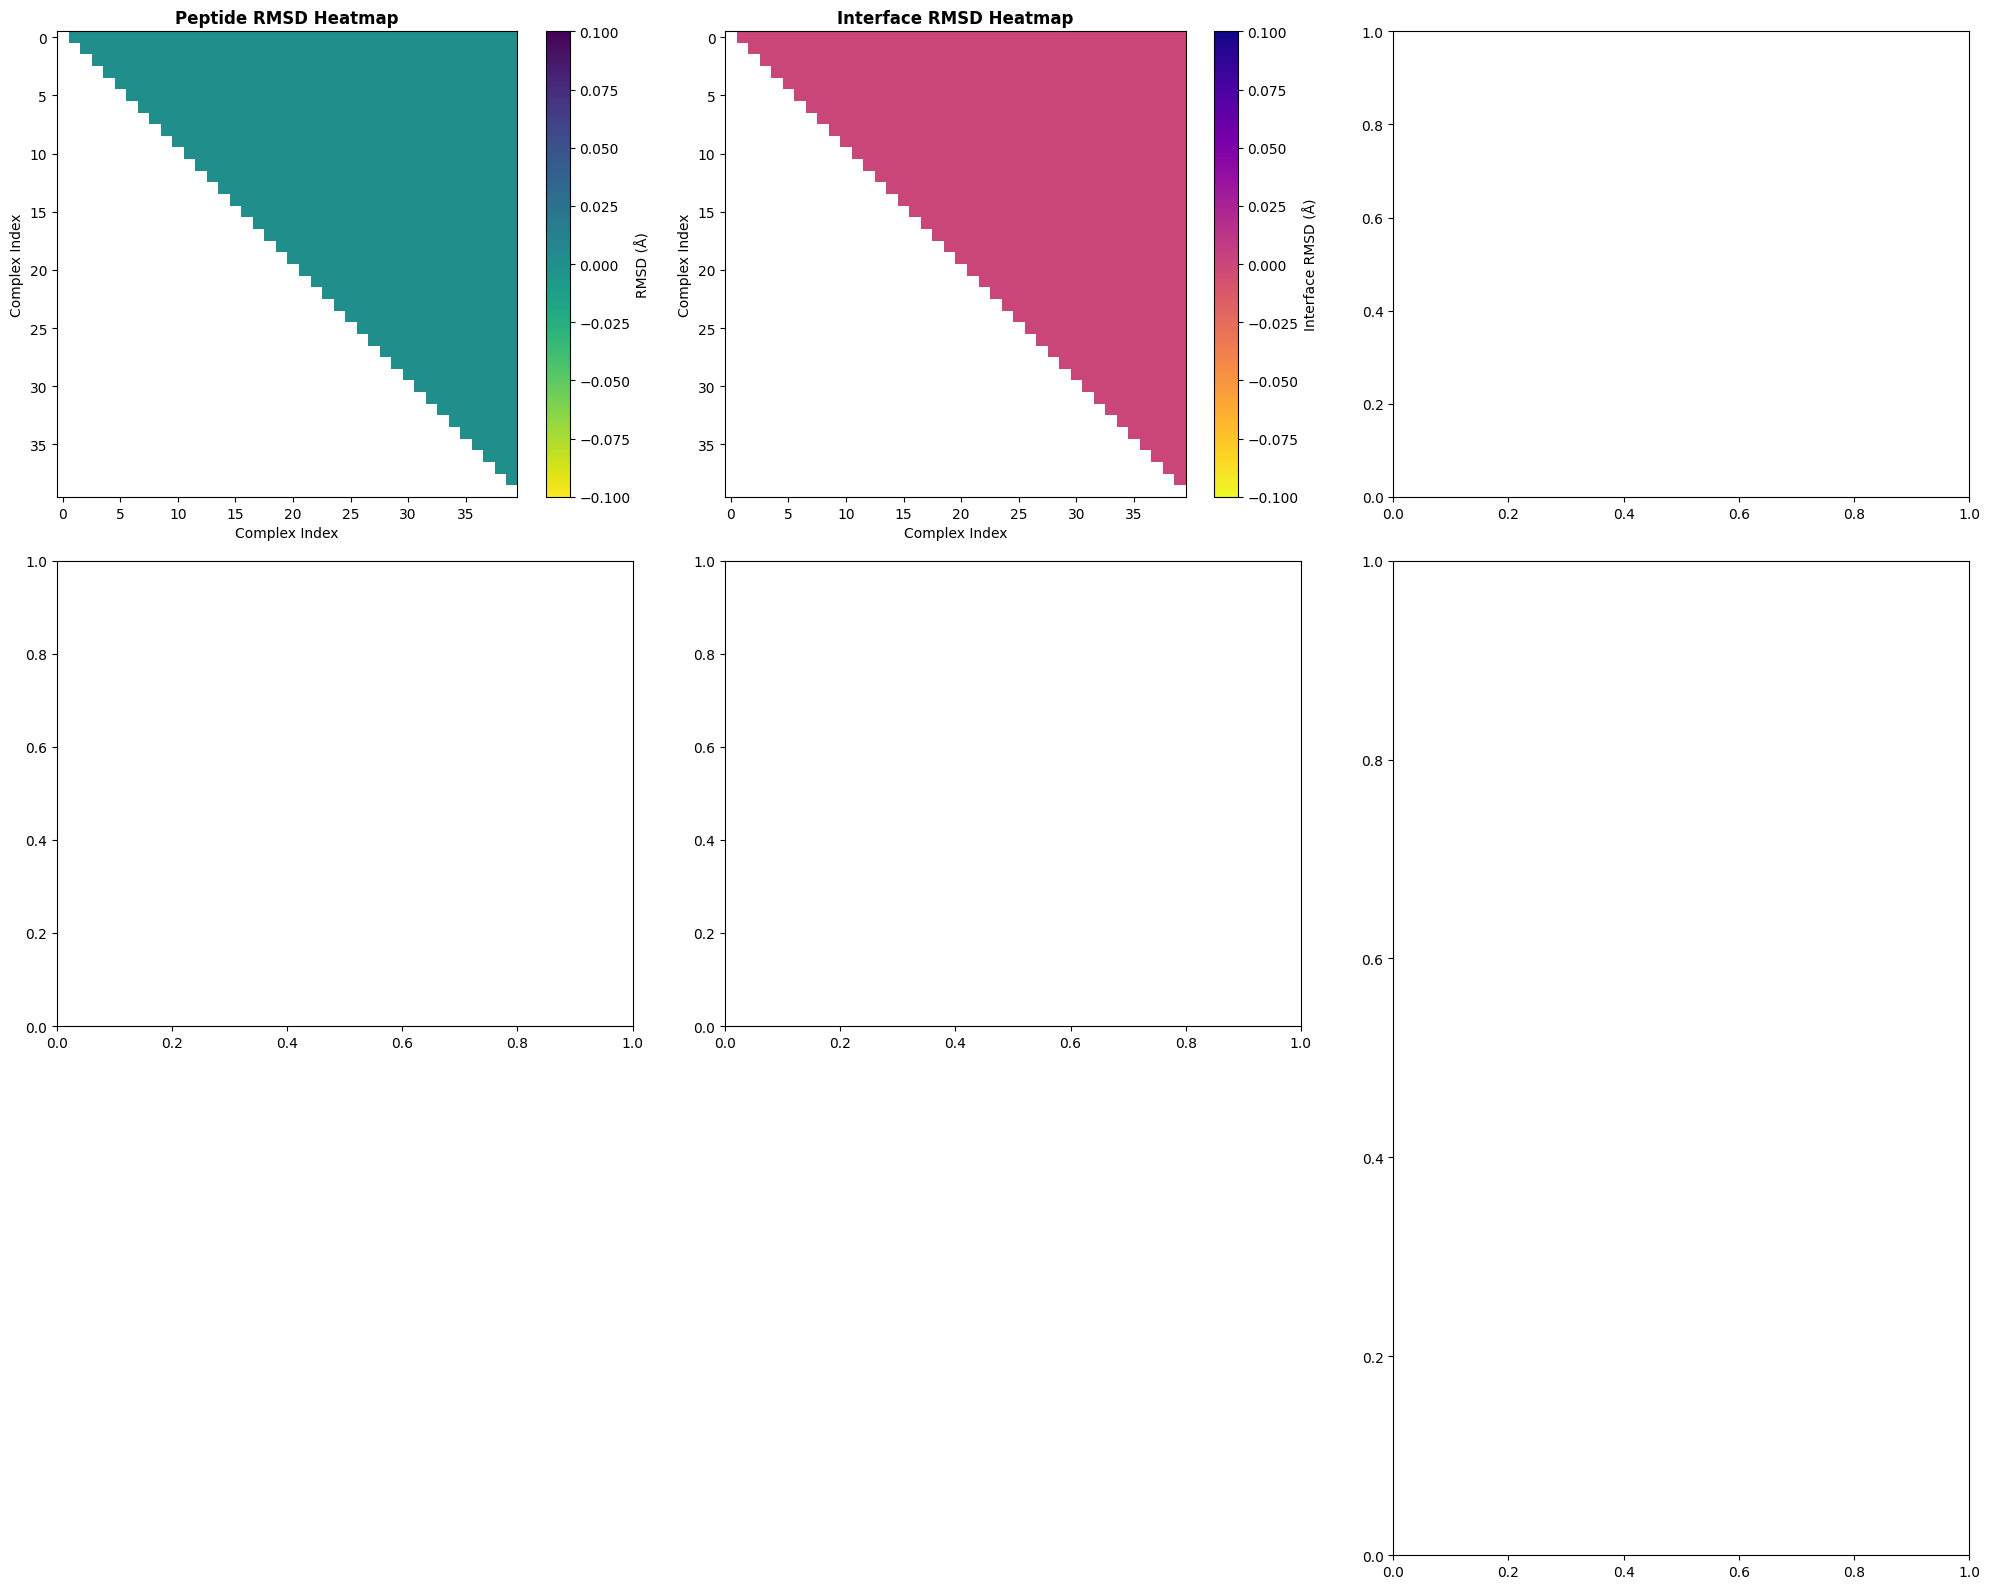


DETAILED ANALYSIS REPORT


KeyError: 'peptide_rmsd'

In [ ]:
#@title Install ColabFold Dependencies
%%time
import os

# Configuration
USE_AMBER = False
USE_TEMPLATES = False
PYTHON_VERSION = '3.10'

if not os.path.isfile("COLABFOLD_READY"):
  print("Installing ColabFold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # Fix for TensorFlow crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("Installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY"):
  print("Installing hhsuite...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
  os.system("touch HH_READY")

if USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("Installing amber...")
  os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch AMBER_READY")

print("Dependencies installed successfully!")

#@title Upload FASTA File and Parse Sequences
from google.colab import files
import io

# Upload the FASTA file
print("Please upload your FASTA file containing MHC-peptide complexes:")
uploaded = files.upload()

# Read the uploaded file
file_name = list(uploaded.keys())[0]
fasta_content = uploaded[file_name].decode('utf-8')

# Parse FASTA file
complex_queries = []
complex_info = []

print("\nParsing FASTA file...")
lines = fasta_content.strip().split('\n')
current_name = ""
current_sequence = ""

for line in lines:
    if line.startswith('>'):
        # Save previous entry if exists
        if current_name and current_sequence:
            # Determine MHC class based on number of chains separated by colons
            num_chains = current_sequence.count(':') + 1
            mhc_class = 'I' if num_chains == 2 else 'II'  # MHC-I: 2 chains, MHC-II: 3+ chains

            # Determine source from name
            source = 'myelin' if 'myelin' in current_name.lower() else 'ebv'

            complex_queries.append((current_name, current_sequence))
            complex_info.append({
                'complex_name': current_name,
                'sequence': current_sequence,
                'num_chains': num_chains,
                'mhc_class': mhc_class,
                'source': source
            })

        # Start new entry
        current_name = line[1:].strip()
        current_sequence = ""
    else:
        current_sequence += line.strip()

# Add last entry
if current_name and current_sequence:
    num_chains = current_sequence.count(':') + 1
    mhc_class = 'I' if num_chains == 2 else 'II'
    source = 'myelin' if 'myelin' in current_name.lower() else 'ebv'

    complex_queries.append((current_name, current_sequence))
    complex_info.append({
        'complex_name': current_name,
        'sequence': current_sequence,
        'num_chains': num_chains,
        'mhc_class': mhc_class,
        'source': source
    })

# Create output directory
jobname = "mhc_docking_analysis"
os.makedirs(jobname, exist_ok=True)

# Save queries to file
queries_path = os.path.join(jobname, "queries.fasta")
with open(queries_path, "w") as f:
    for query_name, query_sequence in complex_queries:
        f.write(f">{query_name}\n{query_sequence}\n")

# Save metadata
import json
metadata_path = os.path.join(jobname, "complex_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(complex_info, f, indent=2)

print(f"\nParsed {len(complex_queries)} MHC-peptide complexes:")
print(f"• MHC Class I complexes: {sum(1 for info in complex_info if info['mhc_class'] == 'I')}")
print(f"• MHC Class II complexes: {sum(1 for info in complex_info if info['mhc_class'] == 'II')}")
print(f"• Myelin peptides: {sum(1 for info in complex_info if info['source'] == 'myelin')}")
print(f"• EBV peptides: {sum(1 for info in complex_info if info['source'] == 'ebv')}")
print(f"\nQueries saved to: {queries_path}")
print(f"Metadata saved to: {metadata_path}")

# Print first few entries as examples
print("\nExample complexes:")
for i, (name, seq) in enumerate(complex_queries[:3]):
    print(f"{name}: {seq[:50]}..." if len(seq) > 50 else f"{name}: {seq}")

#@title Configure ColabFold Parameters
#@markdown ### MSA Options
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}

#@markdown ### Model Settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
num_models = 1 #@param [1, 2, 3, 4, 5] {type:"raw"}
num_recycles = 3 #@param [1, 3, 6, 12, 24] {type:"raw"}
num_seeds = 1 #@param [1, 2, 3, 4, 5] {type:"raw"}

#@markdown ### Advanced Settings
use_dropout = False #@param {type:"boolean"}
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
max_msa = None #@param {type:"raw"}
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
calc_extra_ptm = True #@param {type:"boolean"}

#@markdown ### Output Settings
save_all = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
dpi = 200 #@param {type:"integer"}

print("Configuration complete!")
print(f"Number of complexes: {len(complex_queries)}")

#@title Run MHC Docking Predictions
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

from pathlib import Path
from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type

# Setup logging
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

# Get queries
queries, is_complex = get_queries(queries_path)

# Determine model type based on complex size
max_chains = max(info['num_chains'] for info in complex_info)
if max_chains > 1:
    model_type = "alphafold2_multimer_v3"
else:
    model_type = "alphafold2_ptm"
print(f"Using model type: {model_type}")

# Download AlphaFold parameters
print("Downloading AlphaFold parameters...")
download_alphafold_params(model_type, Path("."))

# Configure MSA settings
if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
else:
    use_cluster_profile = True

print(f"Starting MHC-peptide docking predictions for {len(queries)} complexes...")

# Run predictions
results = run(
    queries=queries,
    result_dir=jobname,
    use_templates=use_templates,
    num_relax=0,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=num_models,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1, 2, 3, 4, 5][:num_models],
    is_complex=True,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy="greedy",
    stop_at_score=float(100),
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    calc_extra_ptm=calc_extra_ptm,
)

# Create results zip
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

print("\n" + "="*60)
print("MHC-PEPTIDE DOCKING COMPLETED!")
print("="*60)
print(f"Results saved in: {jobname}")
print(f"Download results: {results_zip}")

#@title Advanced Structural Analysis and Comparison
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser, Superimposer, Selection, NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_peptide_coordinates(pdb_file, peptide_chain_index):
    """Extract peptide coordinates from PDB file based on chain index"""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('complex', pdb_file)

    peptide_atoms = []
    peptide_sequence = []

    for model in structure:
        chains = list(model.get_chains())
        if peptide_chain_index < len(chains):
            chain = chains[peptide_chain_index]
            for residue in chain:
                # Get CA atom for protein residues
                if 'CA' in residue:
                    peptide_atoms.append(residue['CA'])
                    peptide_sequence.append(residue.get_resname())
                elif len(residue) > 0:
                    # Use first atom for small peptides
                    peptide_atoms.append(list(residue.get_atoms())[0])
                    peptide_sequence.append(residue.get_resname())

    if not peptide_atoms:
        return None, None

    coordinates = np.array([atom.get_coord() for atom in peptide_atoms])
    return coordinates, peptide_sequence

def calculate_rmsd(coords1, coords2):
    """Calculate RMSD between two sets of coordinates"""
    if coords1 is None or coords2 is None:
        return np.nan

    # Ensure same number of atoms
    min_len = min(len(coords1), len(coords2))
    coords1 = coords1[:min_len]
    coords2 = coords2[:min_len]

    # Center coordinates
    coords1_centered = coords1 - np.mean(coords1, axis=0)
    coords2_centered = coords2 - np.mean(coords2, axis=0)

    # Calculate RMSD
    diff = coords1_centered - coords2_centered
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

def calculate_interface_rmsd(pdb_file1, pdb_file2, mhc_chains_indices, peptide_chain_index):
    """Calculate RMSD of MHC-peptide interface residues"""
    parser = PDBParser(QUIET=True)

    # Parse structures
    struct1 = parser.get_structure('complex1', pdb_file1)
    struct2 = parser.get_structure('complex2', pdb_file2)

    # Get interface residues (MHC residues within 5Å of peptide)
    interface_coords1 = []
    interface_coords2 = []

    for struct_idx, (struct, pdb_file) in enumerate([(struct1, pdb_file1), (struct2, pdb_file2)]):
        for model in struct:
            # Get peptide chain
            chains = list(model.get_chains())
            if peptide_chain_index >= len(chains):
                continue

            peptide_chain = chains[peptide_chain_index]
            peptide_atoms = list(peptide_chain.get_atoms())

            if not peptide_atoms:
                continue

            # Find MHC atoms near peptide
            for chain_idx in mhc_chains_indices:
                if chain_idx >= len(chains):
                    continue

                mhc_chain = chains[chain_idx]
                for residue in mhc_chain:
                    for atom in residue:
                        # Check distance to peptide
                        for peptide_atom in peptide_atoms:
                            if np.linalg.norm(atom.coord - peptide_atom.coord) <= 5.0:
                                if 'CA' in residue:
                                    if struct_idx == 0:
                                        interface_coords1.append(residue['CA'].coord)
                                    else:
                                        interface_coords2.append(residue['CA'].coord)
                                break

    if not interface_coords1 or not interface_coords2:
        return np.nan

    # Match interface residues by index (simplified)
    min_len = min(len(interface_coords1), len(interface_coords2))
    coords1 = np.array(interface_coords1[:min_len])
    coords2 = np.array(interface_coords2[:min_len])

    # Calculate RMSD
    return calculate_rmsd(coords1, coords2)

def analyze_pmhc_structures(jobname, complex_info):
    """Perform comprehensive structural analysis on PMHC complexes"""

    # Find all PDB files
    pdb_files = []
    for root, dirs, files in os.walk(jobname):
        for file in files:
            if file.endswith('.pdb') and 'rank_001' in file:
                pdb_files.append(os.path.join(root, file))

    print(f"Found {len(pdb_files)} PDB files for analysis")

    # Map complex names to PDB files
    complex_to_pdb = {}
    for pdb_file in pdb_files:
        complex_name = os.path.basename(pdb_file)
        # Remove common suffixes
        suffixes = [
            '_unrelaxed_rank_001_alphafold2_multimer_v3_model_1.pdb',
            '_unrelaxed_rank_001_alphafold2_ptm_model_1.pdb',
            '_relaxed_rank_001_alphafold2_multimer_v3_model_1.pdb',
            '_relaxed_rank_001_alphafold2_ptm_model_1.pdb'
        ]
        for suffix in suffixes:
            if complex_name.endswith(suffix):
                complex_name = complex_name.replace(suffix, '')
                break
        complex_to_pdb[complex_name] = pdb_file

    # Create comparison matrix
    n_complexes = len(complex_info)
    rmsd_matrix = np.zeros((n_complexes, n_complexes))
    interface_rmsd_matrix = np.zeros((n_complexes, n_complexes))
    comparison_data = []

    # Determine peptide chain index (last chain)
    for i, info_i in enumerate(complex_info):
        complex_name_i = info_i['complex_name']
        pdb_file_i = complex_to_pdb.get(complex_name_i)

        if not pdb_file_i:
            print(f"Warning: No PDB file found for {complex_name_i}")
            continue

        peptide_chain_i = info_i['num_chains'] - 1  # Peptide is last chain
        coords_i, seq_i = extract_peptide_coordinates(pdb_file_i, peptide_chain_i)

        # Determine MHC chain indices (all except peptide)
        mhc_chains_i = list(range(info_i['num_chains'] - 1))

        for j, info_j in enumerate(complex_info):
            if i == j:
                rmsd_matrix[i, j] = 0
                interface_rmsd_matrix[i, j] = 0
                continue

            complex_name_j = info_j['complex_name']
            pdb_file_j = complex_to_pdb.get(complex_name_j)

            if not pdb_file_j:
                rmsd_matrix[i, j] = np.nan
                interface_rmsd_matrix[i, j] = np.nan
                continue

            peptide_chain_j = info_j['num_chains'] - 1
            coords_j, seq_j = extract_peptide_coordinates(pdb_file_j, peptide_chain_j)

            # Calculate peptide RMSD
            rmsd = calculate_rmsd(coords_i, coords_j)
            rmsd_matrix[i, j] = rmsd

            # Calculate interface RMSD
            mhc_chains_j = list(range(info_j['num_chains'] - 1))
            interface_rmsd = calculate_interface_rmsd(pdb_file_i, pdb_file_j, mhc_chains_i, peptide_chain_i)
            interface_rmsd_matrix[i, j] = interface_rmsd

            if i < j:  # Avoid duplicate comparisons
                comparison_data.append({
                    'complex_1': complex_name_i,
                    'complex_2': complex_name_j,
                    'peptide_1': seq_i,
                    'peptide_2': seq_j,
                    'mhc_class_1': info_i['mhc_class'],
                    'mhc_class_2': info_j['mhc_class'],
                    'source_1': info_i['source'],
                    'source_2': info_j['source'],
                    'peptide_rmsd': rmsd,
                    'interface_rmsd': interface_rmsd,
                    'num_chains_1': info_i['num_chains'],
                    'num_chains_2': info_j['num_chains']
                })

    return rmsd_matrix, interface_rmsd_matrix, comparison_data, complex_to_pdb

# Perform structural analysis
print("\n" + "="*60)
print("PERFORMING ADVANCED STRUCTURAL ANALYSIS")
print("="*60)

rmsd_matrix, interface_rmsd_matrix, comparison_data, complex_to_pdb = analyze_pmhc_structures(jobname, complex_info)

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

# Save comparison results
comparison_csv = os.path.join(jobname, "structural_comparisons.csv")
comparison_df.to_csv(comparison_csv, index=False)
print(f"Structural comparisons saved to: {comparison_csv}")

#@title Visualization and Analysis Results
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 16))

# 1. RMSD Heatmap
ax1 = plt.subplot(3, 3, 1)
if not np.all(np.isnan(rmsd_matrix)):
    mask = np.triu(np.ones_like(rmsd_matrix, dtype=bool), k=1)
    heatmap_data = np.where(mask, rmsd_matrix, np.nan)

    im = ax1.imshow(heatmap_data, cmap='viridis_r', aspect='auto', vmin=0, vmax=np.nanmax(heatmap_data))
    ax1.set_title('Peptide RMSD Heatmap', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Complex Index')
    ax1.set_ylabel('Complex Index')
    plt.colorbar(im, ax=ax1, label='RMSD (Å)')
else:
    ax1.text(0.5, 0.5, 'RMSD data unavailable', ha='center', va='center', transform=ax1.transAxes)

# 2. Interface RMSD Heatmap
ax2 = plt.subplot(3, 3, 2)
if not np.all(np.isnan(interface_rmsd_matrix)):
    mask = np.triu(np.ones_like(interface_rmsd_matrix, dtype=bool), k=1)
    heatmap_data = np.where(mask, interface_rmsd_matrix, np.nan)

    im = ax2.imshow(heatmap_data, cmap='plasma_r', aspect='auto', vmin=0, vmax=np.nanmax(heatmap_data))
    ax2.set_title('Interface RMSD Heatmap', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Complex Index')
    ax2.set_ylabel('Complex Index')
    plt.colorbar(im, ax=ax2, label='Interface RMSD (Å)')
else:
    ax2.text(0.5, 0.5, 'Interface RMSD data unavailable', ha='center', va='center', transform=ax2.transAxes)

# 3. RMSD Distribution by Source Comparison
ax3 = plt.subplot(3, 3, 3)
if len(comparison_df) > 0:
    # Create comparison types
    comparison_df['comparison_type'] = comparison_df.apply(
        lambda x: f"{x['source_1']}-{x['source_2']}", axis=1
    )

    # Group data
    groups = []
    labels = []
    colors = []

    for comp_type in ['ebv-ebv', 'myelin-myelin', 'ebv-myelin', 'myelin-ebv']:
        data = comparison_df[comparison_df['comparison_type'] == comp_type]['peptide_rmsd'].dropna()
        if len(data) > 0:
            groups.append(data)
            labels.append(comp_type)
            colors.append('lightblue' if 'ebv' in comp_type else 'lightgreen' if 'myelin' in comp_type else 'lightcoral')

    if groups:
        bp = ax3.boxplot(groups, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax3.set_title('RMSD by Peptide Source', fontsize=12, fontweight='bold')
        ax3.set_ylabel('RMSD (Å)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)

# 4. MHC Class Comparison
ax4 = plt.subplot(3, 3, 4)
if len(comparison_df) > 0:
    mhc_comparisons = comparison_df.groupby(['mhc_class_1', 'mhc_class_2']).agg({
        'peptide_rmsd': ['mean', 'std', 'count']
    }).round(2)

    if not mhc_comparisons.empty:
        positions = np.arange(len(mhc_comparisons))
        means = mhc_comparisons[('peptide_rmsd', 'mean')].values
        stds = mhc_comparisons[('peptide_rmsd', 'std')].values

        bars = ax4.bar(positions, means, yerr=stds, capsize=5,
                      color=['skyblue', 'lightcoral', 'lightgreen'])
        ax4.set_xticks(positions)
        ax4.set_xticklabels([f"{row[0]}-{row[1]}" for row in mhc_comparisons.index], rotation=45)
        ax4.set_title('RMSD by MHC Class', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Mean RMSD (Å)')
        ax4.grid(True, alpha=0.3)

# 5. Correlation between peptide and interface RMSD
ax5 = plt.subplot(3, 3, 5)
if len(comparison_df) > 0:
    valid_data = comparison_df.dropna(subset=['peptide_rmsd', 'interface_rmsd'])
    if len(valid_data) > 10:
        ax5.scatter(valid_data['peptide_rmsd'], valid_data['interface_rmsd'],
                   alpha=0.6, s=50, c='purple')

        # Add regression line
        z = np.polyfit(valid_data['peptide_rmsd'], valid_data['interface_rmsd'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(valid_data['peptide_rmsd'].min(), valid_data['peptide_rmsd'].max(), 100)
        ax5.plot(x_range, p(x_range), "r--", alpha=0.8)

        correlation = np.corrcoef(valid_data['peptide_rmsd'], valid_data['interface_rmsd'])[0,1]
        ax5.text(0.05, 0.95, f'ρ = {correlation:.2f}', transform=ax5.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax5.set_xlabel('Peptide RMSD (Å)')
        ax5.set_ylabel('Interface RMSD (Å)')
        ax5.set_title('Peptide vs Interface RMSD Correlation', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3)

# 6. Hierarchical Clustering Dendrogram
ax6 = plt.subplot(3, 3, (6, 9))  # Span two rows
if len(comparison_df) > 0 and not np.all(np.isnan(rmsd_matrix)):
    # Create condensed distance matrix
    valid_indices = ~np.all(np.isnan(rmsd_matrix), axis=1)
    if np.sum(valid_indices) > 2:
        valid_rmsd = rmsd_matrix[valid_indices][:, valid_indices]
        valid_names = [complex_info[i]['complex_name'] for i in range(len(complex_info)) if valid_indices[i]]

        # Replace NaN with maximum distance
        max_dist = np.nanmax(valid_rmsd)
        valid_rmsd_filled = np.where(np.isnan(valid_rmsd), max_dist * 1.5, valid_rmsd)

        # Perform hierarchical clustering
        try:
            condensed_dist = squareform(valid_rmsd_filled, checks=False)
            Z = linkage(condensed_dist, method='average')

            # Create dendrogram with colored labels
            label_colors = []
            for name in valid_names:
                if 'ebv' in name.lower():
                    label_colors.append('red')
                elif 'myelin' in name.lower():
                    label_colors.append('blue')
                else:
                    label_colors.append('black')

            ddata = dendrogram(Z, labels=valid_names, ax=ax6,
                             leaf_rotation=90, leaf_font_size=8,
                             color_threshold=0.7*np.max(Z[:,2]))

            # Color leaf labels
            for xtick in ax6.get_xticklabels():
                xtick.set_color(label_colors[ddata['leaves'].index(valid_names.index(xtick.get_text()))])

            ax6.set_title('Hierarchical Clustering of PMHC Complexes', fontsize=12, fontweight='bold')
            ax6.set_xlabel('Complexes')
            ax6.set_ylabel('Distance (RMSD)')

            # Add cluster rectangles
            from scipy.cluster.hierarchy import fcluster
            clusters = fcluster(Z, t=0.7*np.max(Z[:,2]), criterion='distance')
            unique_clusters = np.unique(clusters)

            # Draw rectangles around clusters
            current_pos = 0
            for cluster in unique_clusters:
                cluster_size = np.sum(clusters[ddata['leaves']] == cluster)
                if cluster_size > 1:
                    rect = plt.Rectangle((current_pos, 0), cluster_size,
                                       ax6.get_ylim()[1]*0.02,
                                       fill=True, alpha=0.3, color='gray')
                    ax6.add_patch(rect)
                current_pos += cluster_size

        except Exception as e:
            ax6.text(0.5, 0.5, f'Clustering failed: {str(e)}',
                    ha='center', va='center', transform=ax6.transAxes)
    else:
        ax6.text(0.5, 0.5, 'Insufficient data for clustering',
                ha='center', va='center', transform=ax6.transAxes)

plt.tight_layout()
plt.savefig(os.path.join(jobname, 'comprehensive_structural_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

#@title Generate Detailed Analysis Report
print("\n" + "="*60)
print("DETAILED ANALYSIS REPORT")
print("="*60)

# Overall statistics
valid_rmsd = comparison_df['peptide_rmsd'].dropna()
valid_interface = comparison_df['interface_rmsd'].dropna()

if len(valid_rmsd) > 0:
    print("\n1. PEPTIDE RMSD STATISTICS:")
    print(f"   • Total comparisons: {len(comparison_df)}")
    print(f"   • Valid RMSD calculations: {len(valid_rmsd)}")
    print(f"   • Mean RMSD: {valid_rmsd.mean():.2f} ± {valid_rmsd.std():.2f} Å")
    print(f"   • Range: {valid_rmsd.min():.2f} - {valid_rmsd.max():.2f} Å")
    print(f"   • Median: {valid_rmsd.median():.2f} Å")

    print("\n2. INTERFACE RMSD STATISTICS:")
    print(f"   • Valid interface comparisons: {len(valid_interface)}")
    if len(valid_interface) > 0:
        print(f"   • Mean interface RMSD: {valid_interface.mean():.2f} ± {valid_interface.std():.2f} Å")
        print(f"   • Range: {valid_interface.min():.2f} - {valid_interface.max():.2f} Å")

    print("\n3. TOP 5 MOST SIMILAR PAIRS (Lowest Peptide RMSD):")
    top_similar = comparison_df.nsmallest(5, 'peptide_rmsd')
    for idx, row in top_similar.iterrows():
        print(f"   • {row['complex_1']} vs {row['complex_2']}:")
        print(f"     Peptide RMSD: {row['peptide_rmsd']:.2f} Å")
        if not pd.isna(row['interface_rmsd']):
            print(f"     Interface RMSD: {row['interface_rmsd']:.2f} Å")
        print(f"     MHC Classes: {row['mhc_class_1']}/{row['mhc_class_2']}")
        print(f"     Sources: {row['source_1']}/{row['source_2']}")

    print("\n4. TOP 5 MOST DISSIMILAR PAIRS (Highest Peptide RMSD):")
    top_dissimilar = comparison_df.nlargest(5, 'peptide_rmsd')
    for idx, row in top_dissimilar.iterrows():
        print(f"   • {row['complex_1']} vs {row['complex_2']}:")
        print(f"     Peptide RMSD: {row['peptide_rmsd']:.2f} Å")
        if not pd.isna(row['interface_rmsd']):
            print(f"     Interface RMSD: {row['interface_rmsd']:.2f} Å")
        print(f"     MHC Classes: {row['mhc_class_1']}/{row['mhc_class_2']}")
        print(f"     Sources: {row['source_1']}/{row['source_2']}")

    print("\n5. RMSD STATISTICS BY CATEGORY:")

    # By MHC class
    print("\n   a) By MHC Class:")
    mhc_stats = comparison_df.groupby(['mhc_class_1', 'mhc_class_2'])['peptide_rmsd'].agg(['mean', 'std', 'count']).round(2)
    for idx, row in mhc_stats.iterrows():
        print(f"     MHC-{idx[0]} vs MHC-{idx[1]}: {row['mean']:.2f} ± {row['std']:.2f} Å (n={row['count']})")

    # By source
    print("\n   b) By Peptide Source:")
    source_stats = comparison_df.groupby(['source_1', 'source_2'])['peptide_rmsd'].agg(['mean', 'std', 'count']).round(2)
    for idx, row in source_stats.iterrows():
        print(f"     {idx[0]} vs {idx[1]}: {row['mean']:.2f} ± {row['std']:.2f} Å (n={row['count']})")

# Find matched pairs (EBV vs Myelin with same identifier)
print("\n6. MATCHED EBV-MYELIN PAIR ANALYSIS:")
matched_pairs = []
for i in range(len(complex_info)):
    for j in range(i+1, len(complex_info)):
        info_i = complex_info[i]
        info_j = complex_info[j]

        # Extract identifier (e.g., CTL_001 from "CTL_001_myelin")
        id_i = '_'.join(info_i['complex_name'].split('_')[:-1])
        id_j = '_'.join(info_j['complex_name'].split('_')[:-1])

        if id_i == id_j and info_i['source'] != info_j['source']:
            # Find the comparison data
            mask = ((comparison_df['complex_1'] == info_i['complex_name']) &
                    (comparison_df['complex_2'] == info_j['complex_name'])) | \
                   ((comparison_df['complex_1'] == info_j['complex_name']) &
                    (comparison_df['complex_2'] == info_i['complex_name']))

            if mask.any():
                pair_data = comparison_df[mask].iloc[0]
                matched_pairs.append({
                    'identifier': id_i,
                    'ebv_complex': info_i['complex_name'] if info_i['source'] == 'ebv' else info_j['complex_name'],
                    'myelin_complex': info_i['complex_name'] if info_i['source'] == 'myelin' else info_j['complex_name'],
                    'peptide_rmsd': pair_data['peptide_rmsd'],
                    'interface_rmsd': pair_data['interface_rmsd'],
                    'mhc_class': info_i['mhc_class']
                })

if matched_pairs:
    matched_df = pd.DataFrame(matched_pairs)
    print(f"   Found {len(matched_pairs)} matched EBV-Myelin pairs")
    print(f"   Mean peptide RMSD for matched pairs: {matched_df['peptide_rmsd'].mean():.2f} ± {matched_df['peptide_rmsd'].std():.2f} Å")

    # Sort by RMSD
    matched_df = matched_df.sort_values('peptide_rmsd')
    print("\n   Top 3 most similar matched pairs:")
    for idx, row in matched_df.head(3).iterrows():
        print(f"     • {row['identifier']}: {row['peptide_rmsd']:.2f} Å (MHC-{row['mhc_class']})")

    print("\n   Top 3 most dissimilar matched pairs:")
    for idx, row in matched_df.tail(3).iterrows():
        print(f"     • {row['identifier']}: {row['peptide_rmsd']:.2f} Å (MHC-{row['mhc_class']})")

    # Save matched pairs analysis
    matched_csv = os.path.join(jobname, "matched_pairs_analysis.csv")
    matched_df.to_csv(matched_csv, index=False)
    print(f"\n   Matched pairs analysis saved to: {matched_csv}")
else:
    print("   No matched EBV-Myelin pairs found with same identifiers")

# Save detailed report
report_path = os.path.join(jobname, "detailed_analysis_report.txt")
with open(report_path, 'w') as f:
    f.write("COMPREHENSIVE PMHC STRUCTURAL ANALYSIS REPORT\n")
    f.write("="*70 + "\n\n")

    f.write("1. DATASET OVERVIEW\n")
    f.write("-"*40 + "\n")
    f.write(f"Total complexes analyzed: {len(complex_info)}\n")
    f.write(f"MHC Class I complexes: {sum(1 for info in complex_info if info['mhc_class'] == 'I')}\n")
    f.write(f"MHC Class II complexes: {sum(1 for info in complex_info if info['mhc_class'] == 'II')}\n")
    f.write(f"Myelin peptides: {sum(1 for info in complex_info if info['source'] == 'myelin')}\n")
    f.write(f"EBV peptides: {sum(1 for info in complex_info if info['source'] == 'ebv')}\n")
    f.write(f"Total structural comparisons: {len(comparison_df)}\n\n")

    if len(valid_rmsd) > 0:
        f.write("2. STATISTICAL SUMMARY\n")
        f.write("-"*40 + "\n")
        f.write(f"Peptide RMSD (mean ± std): {valid_rmsd.mean():.2f} ± {valid_rmsd.std():.2f} Å\n")
        f.write(f"Peptide RMSD range: {valid_rmsd.min():.2f} - {valid_rmsd.max():.2f} Å\n")
        f.write(f"Peptide RMSD median: {valid_rmsd.median():.2f} Å\n\n")

        if len(valid_interface) > 0:
            f.write(f"Interface RMSD (mean ± std): {valid_interface.mean():.2f} ± {valid_interface.std():.2f} Å\n")
            f.write(f"Interface RMSD range: {valid_interface.min():.2f} - {valid_interface.max():.2f} Å\n\n")

        f.write("3. KEY FINDINGS\n")
        f.write("-"*40 + "\n")

        # Most similar pairs
        f.write("Most Structurally Similar Pairs:\n")
        for idx, row in top_similar.iterrows():
            f.write(f"  • {row['complex_1']} vs {row['complex_2']}: {row['peptide_rmsd']:.2f} Å\n")

        f.write("\nMost Structurally Dissimilar Pairs:\n")
        for idx, row in top_dissimilar.iterrows():
            f.write(f"  • {row['complex_1']} vs {row['complex_2']}: {row['peptide_rmsd']:.2f} Å\n")

        if matched_pairs:
            f.write("\n4. MATCHED EBV-MYELIN PAIR ANALYSIS\n")
            f.write("-"*40 + "\n")
            f.write(f"Total matched pairs identified: {len(matched_pairs)}\n")
            f.write(f"Average RMSD for matched pairs: {matched_df['peptide_rmsd'].mean():.2f} ± {matched_df['peptide_rmsd'].std():.2f} Å\n\n")

            f.write("Individual Matched Pair RMSD Values:\n")
            for _, row in matched_df.iterrows():
                f.write(f"  {row['identifier']}: {row['peptide_rmsd']:.2f} Å (MHC-{row['mhc_class']})\n")

print(f"\nDetailed report saved to: {report_path}")

#@title Download All Results
# Create final results package
print("\nCreating final results package...")
final_zip = "pmhc_comprehensive_analysis_results.zip"
os.system(f"zip -r {final_zip} {jobname}")

print(f"\n✓ ANALYSIS COMPLETE!")
print("="*60)
print(f"\nDownload link: {final_zip}")
print("\nGenerated Files:")
print(f"  • {queries_path} - Input sequences")
print(f"  • {metadata_path} - Complex metadata")
print(f"  • {comparison_csv} - Structural comparisons")
print(f"  • {report_path} - Detailed analysis report")
print(f"  • {os.path.join(jobname, 'comprehensive_structural_analysis.png')} - Analysis plots")
if matched_pairs:
    print(f"  • {os.path.join(jobname, 'matched_pairs_analysis.csv')} - Matched pairs analysis")
print(f"  • All PDB structure files in {jobname}/")
print(f"  • ColabFold log files and results")

print("\nKey Metrics:")
if len(valid_rmsd) > 0:
    print(f"  • Average peptide RMSD: {valid_rmsd.mean():.2f} Å")
    print(f"  • Number of valid comparisons: {len(valid_rmsd)}")
if matched_pairs:
    print(f"  • Matched EBV-Myelin pairs: {len(matched_pairs)}")
    print(f"  • Average RMSD for matched pairs: {matched_df['peptide_rmsd'].mean():.2f} Å")

In [ ]:
import shutil
import os

# Zip the folder
shutil.make_archive('/content/mhc_docking_analysis', 'zip', '/content/mhc_docking_analysis')

# Download to your computer
from google.colab import files
files.download('/content/mhc_docking_analysis.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================================================
#  RECOVERY: skip external MMseqs2, finish with local MSA
# =========================================================
import os, time, json, shutil
from pathlib import Path
from colabfold.batch import get_queries, run

job_name   = "mhc_tetramer_competition"
query_file = os.path.join(job_name, "tetramer_queries.fasta")
out_dir    = Path(job_name)
params_dir = Path("alphafold_params")

# 1.  any already-finished MSAs stay;  we’ll fill the gaps with single-sequence
def rescue_msa(job_tuple):
    job_name = job_tuple[0]
    seq      = job_tuple[1][0]          # first (alpha) sequence
    a3m_file = out_dir / job_name / "msas" / "A.a3m"
    a3m_file.parent.mkdir(parents=True, exist_ok=True)
    if not a3m_file.exists():
        a3m_file.write_text(f">101\n{seq}\n")

# ---- loop ----
queries, is_complex = get_queries(query_file)
for qt in queries:
    rescue_msa(qt)

# 2.  run in *single_sequence* mode  →  no server calls
print("🔧  Finishing with single-sequence MSA (no MMseqs2 server) …")
t0 = time.time()
results = run(
    queries=queries,
    result_dir=out_dir,
    use_templates=False,
    num_relax=0,
    msa_mode="single_sequence",          # <-- key change
    model_type="alphafold2_multimer_v3",
    num_models=1,
    num_recycles=6,
    num_seeds=1,
    model_order=[1],
    is_complex=True,
    data_dir=params_dir,
    keep_existing_results=True,          # keep what already worked
    rank_by="auto",
    pair_mode="unpaired_paired",
    stop_at_score=100,
    dpi=200,
    zip_results=False,
    save_all=False,
    max_msa=None,
    use_cluster_profile=True,
    use_gpu_relax=False,
)

print(f"✅  Single-sequence run finished in {time.time()-t0:.1f} s")
zip_path = f"{job_name}.result.zip"
!cd {job_name} && zip -r ../{zip_path} . -x "*.ipynb_checkpoints*" >/dev/null
print(f"📦  {zip_path} ready")

🔧  Finishing with single-sequence MSA (no MMseqs2 server) …


KeyboardInterrupt: 

🚀 MHC TETRAMER COMPETITION ANALYSIS

⚙️ CONFIG: alphafold2_multimer_v3, HLA-DRB1*15:01
   EBV: 16, Myelin: 17

📝 STEP 0: GENERATING QUERIES
----------------------------------------------------------------------
✅ Generated 33 individual queries -> individual_queries.csv
✅ Generated 10 tetramer queries -> tetramer_queries.csv

🚀 TO RUN COLABFOLD TETRAMER:
   colabfold_batch tetramer_queries.csv tetramer_analysis/ --model-type alphafold2_multimer_v3 --num-recycle 3
   --msa-mode mmseqs2_uniref_env --pair-mode unpaired_paired --num-models 1

🔬 STEP 1: LOADING RESULTS
----------------------------------------------------------------------
🔍 No real results directory found, using real tetramer data...
✅ TETRAMER_LMP2_S1_VS_MOG_S19: Score = 0.635
✅ TETRAMER_LMP2_S3_VS_PLP_S20: Score = 0.585
✅ TETRAMER_EBNA1_S8_VS_GlialCAM_S28: Score = 0.605
✅ TETRAMER_LMP2_S2_VS_MOG_S19: Score = 0.655
✅ TETRAMER_EBNA1_S7_VS_PLP_S22: Score = 0.565
✅ TETRAMER_LMP2_S4_VS_ANO2_S27: Score = 0.545
✅ TETRAMER_BZLF1_

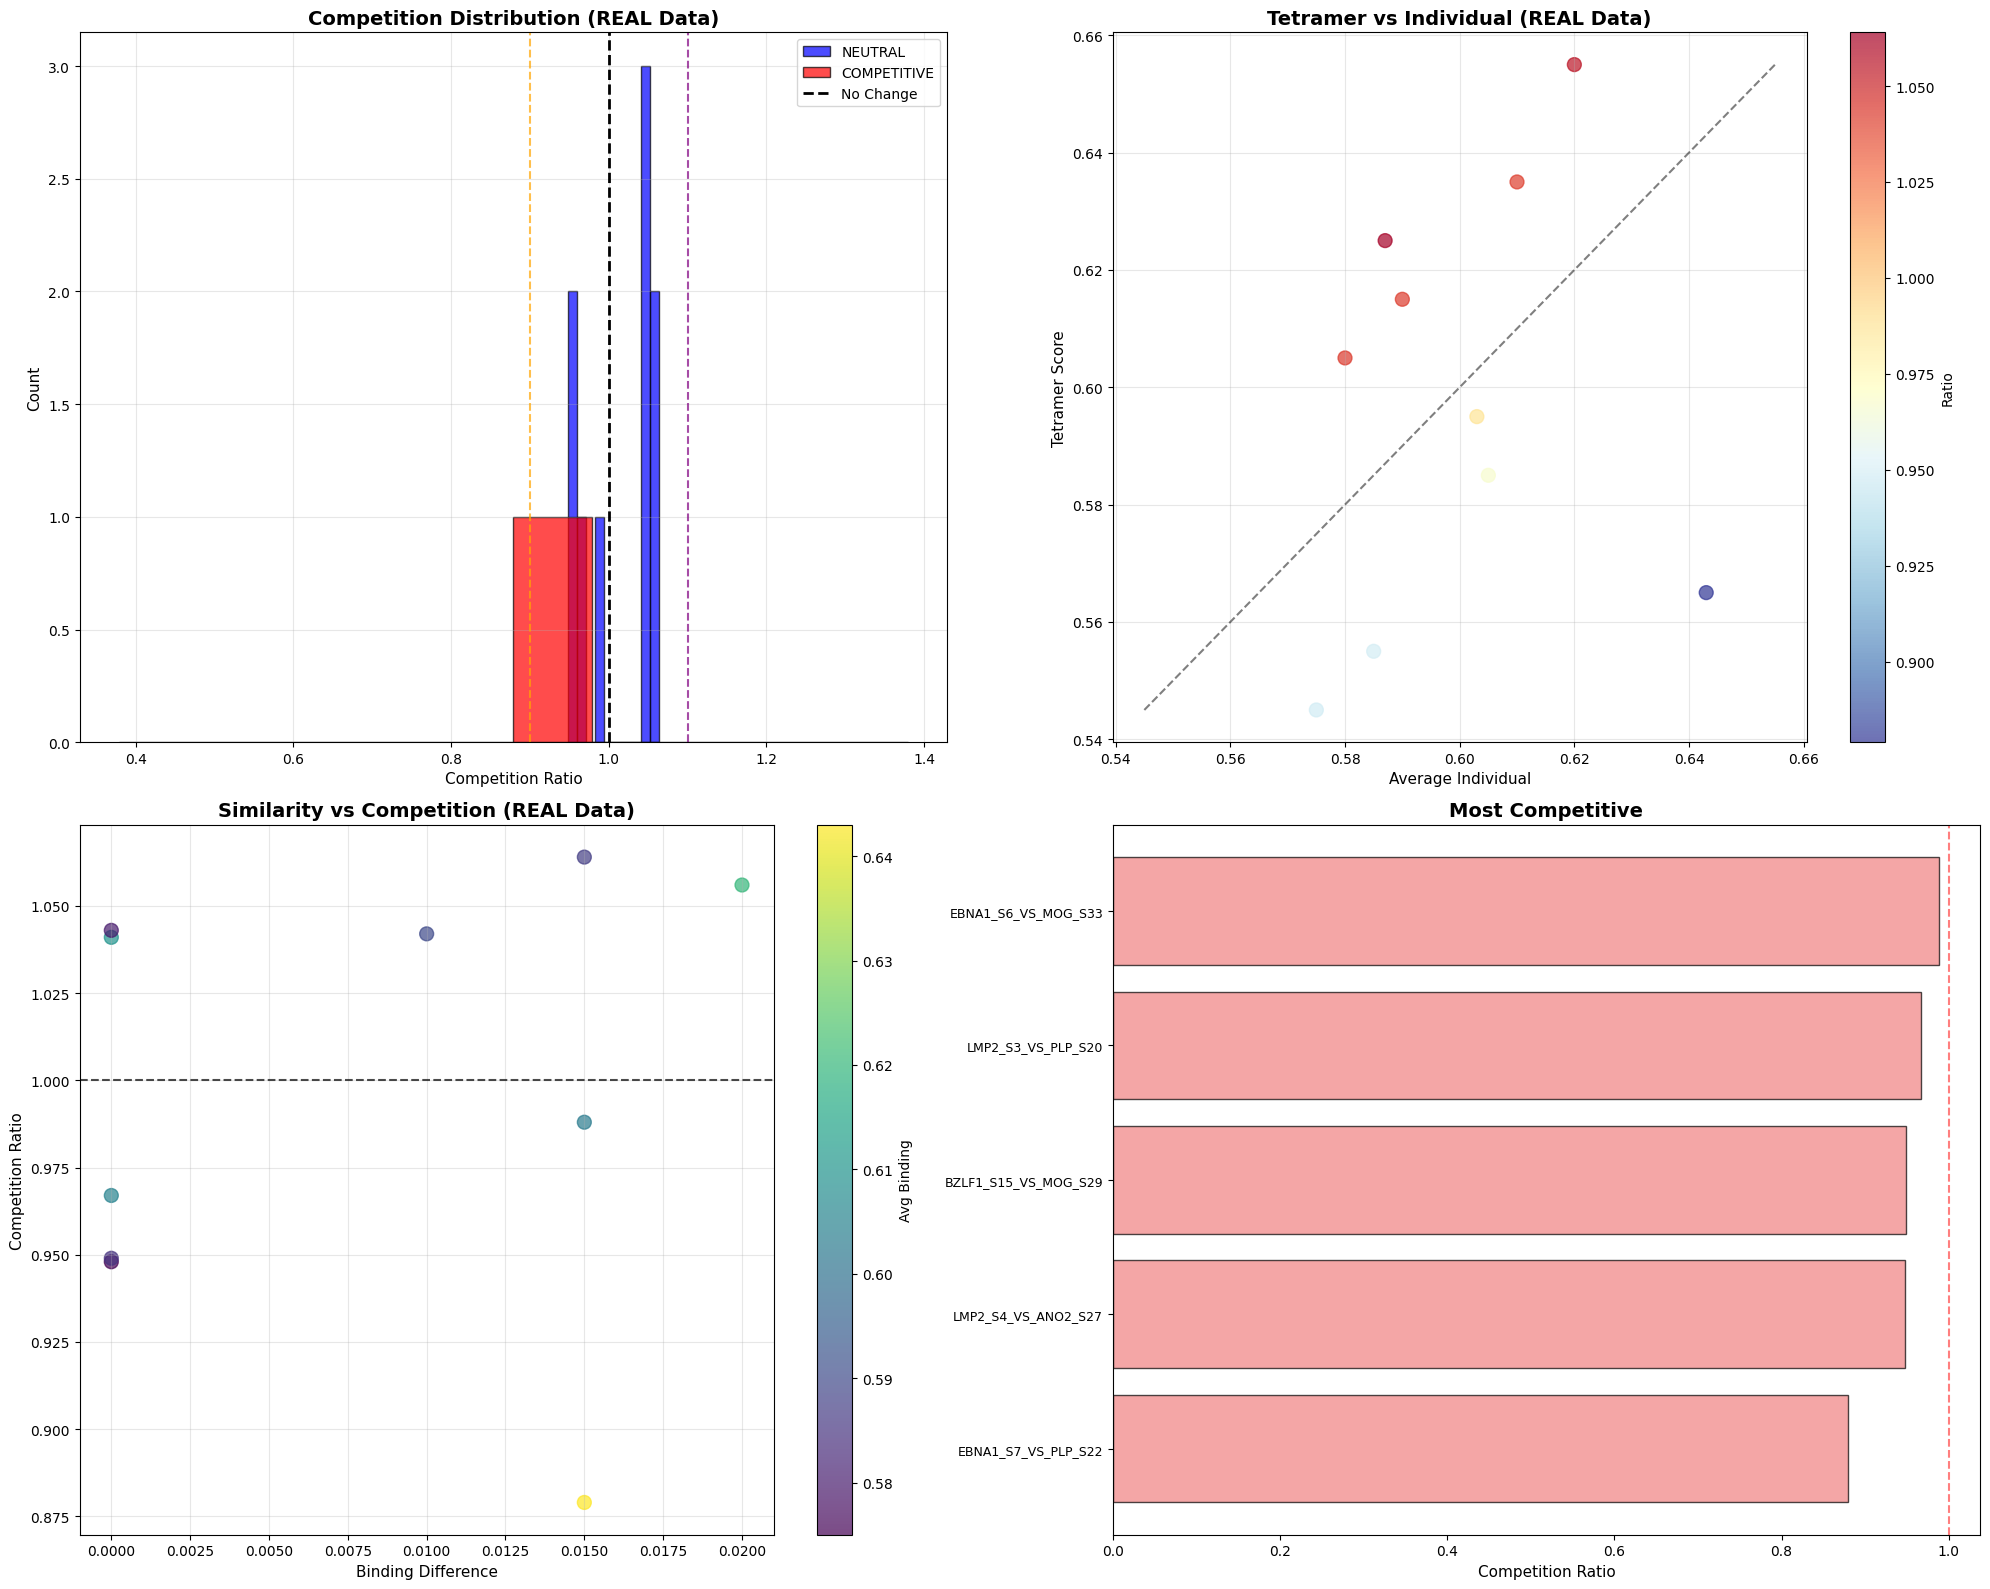

✅ Visualization saved

💾 STEP 6: EXPORTING RESULTS
----------------------------------------------------------------------

💾 Exporting to mhc_tetramer_competition_analysis.xlsx...
✅ Exported to mhc_tetramer_competition_analysis.xlsx

🎉 ANALYSIS COMPLETE!

📊 FINAL STATS:
   Total pairs: 10
   Data quality: 100.0% real
   Strong mimicry: 1
   Competitive: 1
   Co-existing: 0

📁 OUTPUT FILES:
   ✅ mhc_tetramer_competition_analysis.xlsx
   ✅ competition_analysis.png
   ✅ tetramer_queries.csv
   ✅ individual_queries.csv

🚀 NEXT STEPS:
   1. Run ColabFold Tetramer: colabfold_batch tetramer_queries.csv tetramer_analysis/ --model-type alphafold2_multimer_v3 --num-recycle 3 --msa-mode mmseqs2_uniref_env --pair-mode unpaired_paired
   2. Review mhc_tetramer_competition_analysis.xlsx
   3. Check 'Strong_Mimicry' sheet
   4. Validate experimentally
   5. Analyze 3D structures

💡 INTERPRETATION:
   🔴 Competitive (< 0.9): Molecular mimicry
   🔵 Neutral (0.9-1.1): Independent
   🟢 Co-exist (> 1.1): D

In [ ]:
tetramer_df, comparison_df = run_analysis()